In [1]:
#conda install orbingol::geomdl

In [2]:
#conda install conda-forge::opencv

In [3]:
#conda install conda-forge::numpy-stl

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, RandomSampler
import os
import json
from matplotlib import pyplot as plt
import mask
import functional as fn
import visualization as vis
from sklearn.neighbors import KNeighborsRegressor
import pandas as pd
import numpy as np

from PIL import Image
import torch.nn.functional as F
import re

# Constants

In [ ]:
RUN_TYPE = 'test'

DEVICE = 'cuda'

L1 = 0.0025
L2 = 0.01
H_2 = 0.0005

MU = 3e-3
RHO = 1050
V_MAX = 0.3
P_MAX = 90.
Q = (V_MAX / 2) * 2 * H_2


N = 257
N_POINTS = 1000

METHOD = 'PINN'
USE_WEIGHT_OPT = False
N_NEURONS = 48#32
N_LAYERS = 15#10
SCHEDULER_GAMMA = 0.999 # 0.99
SCHEDULER_PATIENCE = 140
BATCH_SIZE = 6 #3
EPOCHS = 120000

N_INTERIOR = 500
N_WALLS = 250
N_INLET = 100
N_OUTLET = 100
N_BOUNDARY = N_WALLS + N_INLET + N_OUTLET

W_RES = 0.02
W_DIV = 0.02
W_V0 = 10000.
W_V_INLET = 1000. #1000.
W_P_OUTLET = 1.

if USE_WEIGHT_OPT:
    W_RES = torch.tensor(W_RES).to('cuda')
    W_RES.requires_grad_(True)
    W_DIV = torch.tensor(W_DIV).to('cuda')
    W_DIV.requires_grad_(True)
    W_V0 = torch.tensor(W_V0).to('cuda')
    W_V0.requires_grad_(True)
    W_V_INLET = torch.tensor(W_V_INLET).to('cuda')
    W_V_INLET.requires_grad_(True)
    W_P_OUTLET = torch.tensor(W_P_OUTLET).to('cuda')
    W_P_OUTLET.requires_grad_(True)

# NORM_IN_SUB = torch.tensor([0.75, 4., 0, 0]).reshape(1, 1, 4).to(DEVICE)
# NORM_IN_DIV = torch.tensor([0.33333, 1., 0.5 * L1, 0.5 * L2]).reshape(1, 1, 4).to(DEVICE)
NORM_OUT = torch.tensor([V_MAX, V_MAX, P_MAX]).reshape(1, 1, 3).to(DEVICE)

vis.set_params(12, L1, L2, 5)

LATENT_DIM = 128 #3
FINE_TUNE = False

# Dataset

In [6]:
def sampler(x, n):
    ind = torch.randperm(len(x))[:n]
    return x[ind]


class ClassDataset(Dataset):
    def __init__(self, path, encoder):
        self.interior = []
        self.walls = []
        self.inlet = []
        self.outlet = []
        self.center = []
        self.h = []

        self.encoder = encoder

        files = os.listdir(path)

        png_files = [f for f in os.listdir(path) if f.lower().endswith('.png')]
        count = len(png_files)

        self.masks = torch.zeros(len(files), 1, N, N).float()
        self.embeding = torch.zeros(len(files), 128).float() #torch.zeros(len(files), 2).float() #torch.zeros(len(files), 3).float()

        for idx in range(len(files)):
            file_path = os.path.join(path, files[idx])
            if '.stl' in file_path:
                pass
                # mask_, x_interior, x_walls, x_inlet, x_outlet, center, h = mask.load_stl(file_path, N,
                #                                                             N_POINTS * N_INTERIOR,
                #                                                             N_POINTS * N_WALLS,
                #                                                             N_POINTS * N_INLET,
                #                                                             N_POINTS * N_OUTLET,
                #                                                             length=[L1, L1, L2],
                #                                                             device='cuda',
                #                                                             use_3d=False,
                #                                                             inside_buffer= 0.001)
                
                # self.interior.append(x_interior)
                # self.walls.append(x_walls)
                # self.inlet.append(x_inlet)
                # self.outlet.append(x_outlet)
                # self.center.append(torch.tensor(center).to(DEVICE))
                # self.h.append(torch.tensor(h).to(DEVICE))
                
                # self.masks[idx] = mask_['num']
                # self.embeding[idx, 0] = float(files[idx].split('_')[1].replace('-', '.'))
                # self.embeding[idx, 1] = float(files[idx].split('_')[3][0])
            else:
                mask_, x_interior, x_walls, x_inlet, x_outlet, center, h = mask.img_to_mask(file_path, N,
                                                                            N_POINTS * N_INTERIOR,
                                                                            N_POINTS * N_WALLS,
                                                                            N_POINTS * N_INLET,
                                                                            N_POINTS * N_OUTLET,
                                                                            length=[L1, L1, L2],
                                                                            device='cuda',
                                                                            use_3d=False,
                                                                            inside_buffer= 0.001)
                
                self.interior.append(x_interior)
                self.walls.append(x_walls)
                self.inlet.append(x_inlet)
                self.outlet.append(x_outlet)
                self.center.append(torch.tensor(center).to(DEVICE))
                self.h.append(torch.tensor(h).to(DEVICE))
                
                self.masks[idx] = mask_['num']
                
                # self.embeding[idx, 0] = float(files[idx].split('_')[1].replace('-', '.'))
                # self.embeding[idx, 1] = float(files[idx].split('_')[3][0])

                img = Image.open(file_path)
                img_array = np.array(img)
                img_tensor = torch.from_numpy(img_array / 255.0).float().unsqueeze(0).unsqueeze(0).to(DEVICE)

                with torch.no_grad():
                    self.embeding[idx] = self.encoder(img_tensor)

                # numbers = re.findall(r'idx_(\d+)_(\d+)_(\d+)\.png', files[idx])
                # self.embeding[idx] = torch.tensor([int(n) for n in numbers[0]])

        self.sampler = sampler

    def __len__(self):
        return len(self.masks)

    def __getitem__(self, idx):
        x_interior = self.sampler(self.interior[idx], N_INTERIOR).to(DEVICE)

        emb_interior = self.embeding[idx].repeat(N_INTERIOR, 1).to(DEVICE)
        
        inputs_boundary = torch.cat((emb_interior[0].repeat(N_BOUNDARY, 1),
                                torch.cat((self.sampler(self.walls[idx], N_WALLS),
                                           self.sampler(self.inlet[idx], N_INLET),
                                           self.sampler(self.outlet[idx], N_OUTLET))).to(DEVICE)), 1)
        return emb_interior, x_interior, inputs_boundary, self.masks[idx], self.center[idx], self.h[idx]
        
def sample_boundarys(x):
    x_walls = x[:, :N_WALLS]
    x_inlet = x[:, N_WALLS:N_WALLS + N_INLET]
    x_outlet = x[:, N_WALLS + N_INLET:N_WALLS + N_INLET + N_OUTLET]

    return x_walls, x_inlet, x_outlet


def sample_v_inlet(inputs, center, h):
    with torch.no_grad():
        v_inlet_2 = (-((inputs[..., -2] - center) / - h) ** 2 + 1) * (2 * Q / (2 * h))
        v_inlet_1 = torch.zeros_like(v_inlet_2)
    return torch.stack((v_inlet_1, v_inlet_2), 2)


# ANN

## CAE

In [7]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),  # 672 -> 336
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # 336 -> 168
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),  # 168 -> 84
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),  # 84 -> 42
            nn.ReLU(),
            nn.Conv2d(256, 512, 3, stride=2, padding=1),  # 42 -> 21
            nn.ReLU(),
        )
        self.flatten_dim = 512 * 21 * 21
        self.fc = nn.Linear(self.flatten_dim, latent_dim)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


class Decoder(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 512 * 21 * 21)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, output_padding=1),  # 21 -> 42
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),  # 42 -> 84
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),   # 84 -> 168
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),    # 168 -> 336
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),     # 336 -> 672
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 512, 21, 21)
        return self.deconv(x)


class CAE(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

In [8]:
cae_model = CAE(latent_dim=128).to(DEVICE)
cae_model.load_state_dict(torch.load("models_cae/best_val_cae.pth"))
encoder = cae_model.encoder
encoder.eval()

Encoder(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): ReLU()
  )
  (fc): Linear(in_features=225792, out_features=128, bias=True)
)

In [9]:
def calculate_latent_stats(dataset_path, encoder, device='cuda'):
    encoder.eval()
    latent_vectors = []
    
    files = os.listdir(dataset_path)

    for idx in range(len(files)):
        file_path = os.path.join(dataset_path, files[idx])
        if '.png' in file_path:

            img = Image.open(file_path)
            img_array = np.array(img)
            img_tensor = torch.from_numpy(img_array / 255.0).float().unsqueeze(0).unsqueeze(0).to(DEVICE)

            with torch.no_grad():
                embedding = encoder(img_tensor).cpu().numpy()
                latent_vectors.append(embedding)
            
            # numbers = re.findall(r'idx_(\d+)_(\d+)_(\d+)\.png', files[idx])
            # embedding = np.array([int(n) for n in numbers[0]])
            # latent_vectors.append(embedding)

    latent_array = np.vstack(latent_vectors)
    #latent_array = np.concatenate(latent_vectors, axis=0)
    mean = latent_array.mean(axis=0).astype(np.float32)
    std = latent_array.std(axis=0).astype(np.float32)
    return mean, std

In [10]:
emb_mean, emb_std = calculate_latent_stats('dataset/mini_train',encoder)
print(f'mean = {emb_mean.shape}\nstd = {emb_std.shape}')

mean = (128,)
std = (128,)


In [11]:
np.concatenate([emb_mean, np.array([0, 0])]).shape

(130,)

In [12]:
NORM_IN_SUB = torch.tensor(np.concatenate([emb_mean, np.array([0, 0])])).float().reshape(1, 1, LATENT_DIM+2).to(DEVICE)
NORM_IN_DIV = torch.tensor(np.concatenate([emb_std + 1e-8, np.array([0.5 * L1, 0.5 * L2])])).float().reshape(1, 1, LATENT_DIM+2).to(DEVICE)
print(NORM_IN_SUB.shape)
print(NORM_IN_DIV.shape)
print(NORM_IN_SUB)
print(NORM_IN_DIV)

torch.Size([1, 1, 130])
torch.Size([1, 1, 130])
tensor([[[  11.6071,   20.3318,   13.8475,  -15.3885,   82.2679,    6.1720,
            19.0668, -114.3143,  -46.3252,   49.3773,    5.4256,  -10.9071,
           -98.1749,   -7.9131,  194.2498,   -6.7516, -118.6059, -169.8710,
             2.7701,   12.5041,   -2.5734,   86.3718,   -3.7727,  124.6458,
             4.9596,    8.2608,  -11.9781, -108.2147,  124.1154, -127.1021,
            48.5722,  -99.6992,    1.4409,   31.0491,    4.1517,    5.3251,
            96.2635,   29.0893, -228.2748,  103.0027,    1.5402,    6.8091,
            -9.8134,   10.4035,  -18.9028,   64.9519,   10.7893,  -45.3423,
            11.2272,  -37.5027,  -11.2945,   66.8732,   55.1477,  -21.3632,
            17.0929,  -87.3683,   25.1721,   -8.4638,  -10.5856,  -57.1133,
           -27.0856,  228.0815,   45.6843,   24.0681,  -30.5249,  -88.6377,
             4.1237,    3.3418,   46.9667,  -67.5237,  -15.4847,   -4.5766,
             5.7593,   20.3770,  -17.643

## PINN

In [13]:
def create_layers(input_size, hidden_layer_size, hidden_layers, output_size):
    layers = []
    for i in range(hidden_layers):
        if not i:
            layers += [nn.Linear(input_size, hidden_layer_size, bias=True),
                       nn.SiLU(inplace=True)]
            torch.nn.init.xavier_normal_(layers[-2].weight)
        else:
            layers += [nn.Linear(hidden_layer_size, hidden_layer_size, bias=True),
                       nn.SiLU(inplace=True)]
            torch.nn.init.xavier_normal_(layers[-2].weight)
            
    layers.append(nn.Linear(hidden_layer_size, output_size, bias=True))
    torch.nn.init.xavier_normal_(layers[-1].weight)
    
    return layers


class MLP(nn.Module):
    def __init__(self, hyp):
        super(MLP, self).__init__()
        input_size = 130 #5 # 4
        
        output_size = 3 if METHOD == 'PINN' else 2
        self.mlp = []
        for i in range(output_size):
            layers = create_layers(input_size, hyp['hidden_layer_size'], hyp['hidden_layers'], 1)
            self.mlp.append(nn.Sequential(*layers))
        self.mlp1, self.mlp2, self.mlp3 = self.mlp
        self.output_size = output_size
    
    def forward(self, x):
        y = []
        for i in range(self.output_size):
            y.append(self.mlp[i]((x - NORM_IN_SUB) / NORM_IN_DIV) * NORM_OUT[..., i])
        return torch.cat(y, 2)

# Load train data

In [14]:
train_dataset = ClassDataset('dataset/mini_train', encoder)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

Mask generation with path: dataset/mini_train\idx_1_5_0.png
done

Interior points generation
done

Walls points generation
done

Inlet points generation
done

Outlet points generation
done


Mask generation with path: dataset/mini_train\idx_1_5_100.png
done

Interior points generation
done

Walls points generation
done

Inlet points generation
done

Outlet points generation
done


Mask generation with path: dataset/mini_train\idx_1_5_20.png
done

Interior points generation
done

Walls points generation
done

Inlet points generation
done

Outlet points generation
done


Mask generation with path: dataset/mini_train\idx_1_5_40.png
done

Interior points generation
done

Walls points generation
done

Inlet points generation
done

Outlet points generation
done


Mask generation with path: dataset/mini_train\idx_1_5_60.png
done

Interior points generation
done

Walls points generation
done

Inlet points generation
done

Outlet points generation
done


Mask generation with path: dataset/mini_

# Training

In [15]:
if RUN_TYPE == 'train':
    best_loss = 1e10

    hyp = {'hidden_layer_size': N_NEURONS, 'hidden_layers': N_LAYERS}
    if FINE_TUNE:
        model = MLP(hyp).to(DEVICE)
        model.load_state_dict(torch.load(f'work/{METHOD}_{SCHEDULER_PATIENCE}.pth'))
        with open(f'work/{METHOD}_history_{SCHEDULER_PATIENCE}.json', 'r') as fp:
            losses = json.load(fp)
    else: 
        model = MLP(hyp).to(DEVICE)
        losses = {'residual_loss': [],
              'div(v)_loss': [],
              'ns_loss': [],
              'v_inlet_loss': [],
              'p_outlet_loss': [],
              'PINN_loss': [],
              'lr': []}

    if USE_WEIGHT_OPT:
        optimizer = torch.optim.Adam([{'params': model.parameters(), 'lr': 1e-3, 'weight_decay': 0.},
                                    {'params': [W_RES, W_DIV, W_V0, W_V_INLET, W_P_OUTLET], 'lr': 1e-3, 'weight_decay': 0.}],
                                    lr=1e-3, weight_decay=0.)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.)

    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=SCHEDULER_GAMMA)

    
    for i in range(EPOCHS):
        print(f"\rEpoch: {i+1}", end="", flush=True)
        n_iter = 0.

        losses['residual_loss'].append(0.)
        losses['div(v)_loss'].append(0.)
        losses['ns_loss'].append(0.)
        losses['v_inlet_loss'].append(0.)
        losses['p_outlet_loss'].append(0.)
        losses['PINN_loss'].append(0.)
        losses['lr'].append(0.)

        for emb_interior, x_interior, inputs_boundary, mask_, center, h in train_loader:
            optimizer.zero_grad()

            x_interior.requires_grad_(True)

            inputs_interior = torch.cat((emb_interior,
                                        x_interior), 2)
            
            outputs_interior = model(inputs_interior)

            outputs_walls, outputs_inlet, outputs_outlet = sample_boundarys(model(inputs_boundary))

            dv1, dv2, d2v1, d2v2, dp = fn.calc_grad(outputs_interior, x_interior)
            
            res_loss = fn.zero_loss(fn.calc_res(outputs_interior, dv1, dv2, d2v1, d2v2, dp, MU, RHO))
            div_loss = fn.mse_zero_loss(fn.calc_div(dv1, dv2))
            v0_loss = fn.mse_zero_loss(outputs_walls[..., :2])
            v_inlet_loss = torch.nn.functional.mse_loss(outputs_inlet[..., :2], sample_v_inlet(sample_boundarys(inputs_boundary)[1],
                                                                                               center.unsqueeze(1),
                                                                                               h.unsqueeze(1)))
            p_outlet_loss = fn.mse_zero_loss(outputs_outlet[..., 2])

            loss = W_RES * res_loss + W_DIV * div_loss + W_V0 * v0_loss + W_V_INLET * v_inlet_loss + W_P_OUTLET * p_outlet_loss
            loss.backward()

            losses['residual_loss'][-1] += (res_loss.item())
            losses['div(v)_loss'][-1] += (div_loss.item())
            losses['ns_loss'][-1] += (v0_loss.item())
            losses['v_inlet_loss'][-1] += (v_inlet_loss.item())
            losses['p_outlet_loss'][-1] += (p_outlet_loss.item())
            losses['PINN_loss'][-1] += (loss.item())
            losses['lr'][-1] += (lr_scheduler.get_last_lr()[0])

            n_iter += 1

            optimizer.step()


        losses['residual_loss'][-1] /= n_iter
        losses['div(v)_loss'][-1] /= n_iter
        losses['ns_loss'][-1] /= n_iter
        losses['v_inlet_loss'][-1] /= n_iter
        losses['p_outlet_loss'][-1] /= n_iter
        losses['PINN_loss'][-1] /= n_iter
        losses['lr'][-1] /= n_iter

        
        if losses['PINN_loss'][-1] < best_loss:
            best_loss = losses['PINN_loss'][-1]
            torch.save(model.state_dict(), f'work/{METHOD}_{SCHEDULER_PATIENCE}.pth')
            torch.save(optimizer.state_dict(), f'work/{METHOD}_opt_{SCHEDULER_PATIENCE}.pth')
            

        if (not i % 1000) and i:
            print(f'\nIteration {i + 1} | ', end='')
            print(f'res_loss: {losses['residual_loss'][-1]} | ', end='')
            print(f'div(v)_loss: {losses['div(v)_loss'][-1]} | ', end='')
            print(f'ns_loss: {losses['ns_loss'][-1]} | ', end='')
            print(f'v_inlet_loss: {losses['v_inlet_loss'][-1]} | ', end='')
            print(f'p_outlet_loss: {losses['p_outlet_loss'][-1]} | ', end='')
            print(f'loss: {losses['PINN_loss'][-1]} | ', end='')
            print(f'lr: {losses['lr'][-1]}')
            with open(f'work/{METHOD}_history_{SCHEDULER_PATIENCE}.json', 'w') as fp:
                json.dump(losses, fp)
            
            
        if (not i % SCHEDULER_PATIENCE):
            lr_scheduler.step()

    optimizer.zero_grad()
        
    del x_interior, inputs_interior, emb_interior, inputs_boundary, mask_
    del outputs_interior, outputs_walls, outputs_inlet, outputs_outlet
    del dv1, dv2, d2v1, d2v2, dp
    del res_loss, div_loss, v0_loss, v_inlet_loss, p_outlet_loss, loss


# Save results

In [16]:
if RUN_TYPE == 'train':
    torch.save(model.state_dict(), f'work/{METHOD}_{SCHEDULER_PATIENCE}.pth')
    torch.save(optimizer.state_dict(), f'work/{METHOD}_opt_{SCHEDULER_PATIENCE}.pth')
    with open(f'work/{METHOD}_history_{SCHEDULER_PATIENCE}.json', 'w') as fp:
        json.dump(losses, fp)


# Load saved model

In [17]:
hyp = {'hidden_layer_size': N_NEURONS, 'hidden_layers': N_LAYERS}

model = MLP(hyp).to(DEVICE)
model.load_state_dict(torch.load(f'work/{METHOD}_{SCHEDULER_PATIENCE}.pth'))

with open(f'work/{METHOD}_history_{SCHEDULER_PATIENCE}.json', 'r') as fp:
    losses = json.load(fp)

# Plot training history

In [18]:
for i in losses:
    print(i)

residual_loss
div(v)_loss
ns_loss
v_inlet_loss
p_outlet_loss
PINN_loss
lr


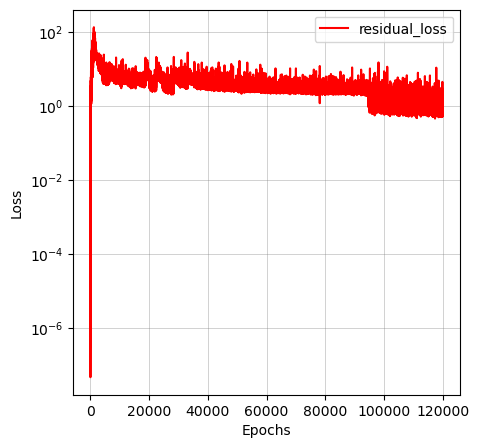

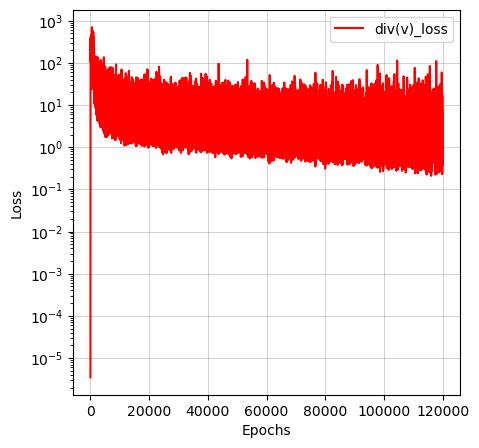

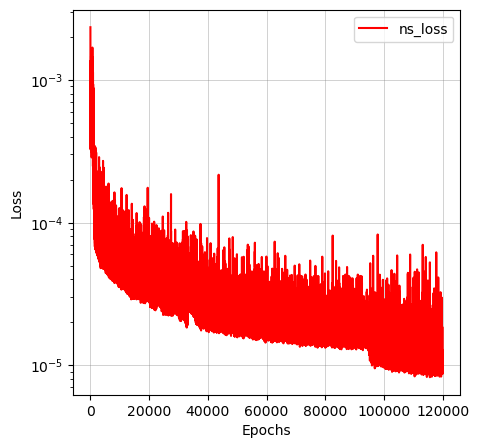

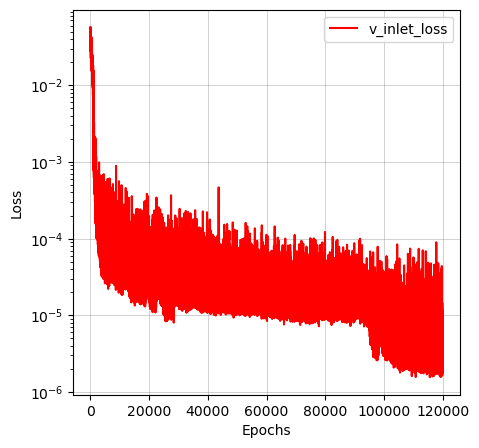

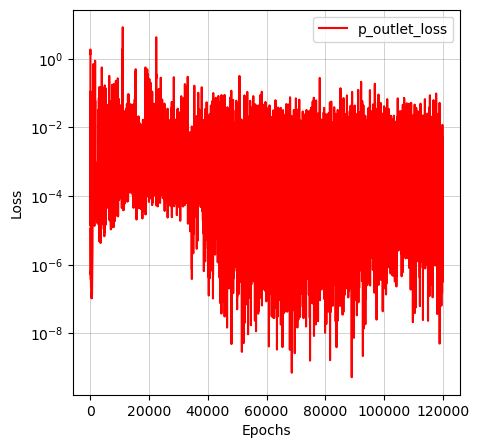

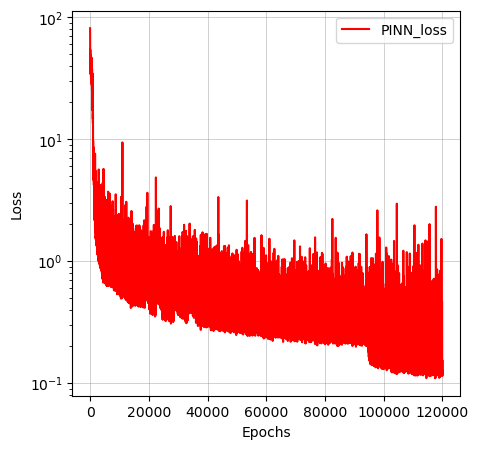

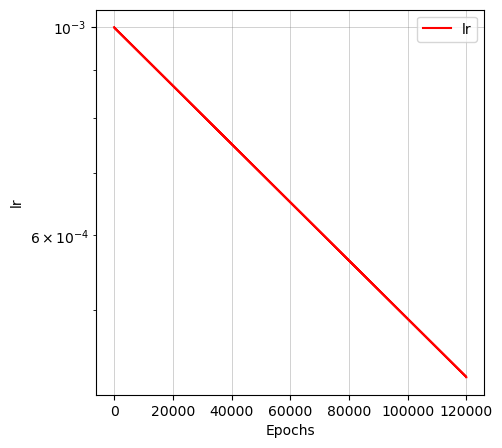

In [19]:
vis.train_history_plot(losses)

# Load test data

In [20]:
train_dataset = ClassDataset('dataset/mini_train',encoder)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)

val_dataset = ClassDataset('dataset/mini_val',encoder)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

Mask generation with path: dataset/mini_train\idx_1_5_0.png
done

Interior points generation
done

Walls points generation
done

Inlet points generation
done

Outlet points generation
done


Mask generation with path: dataset/mini_train\idx_1_5_100.png
done

Interior points generation
done

Walls points generation
done

Inlet points generation
done

Outlet points generation
done


Mask generation with path: dataset/mini_train\idx_1_5_20.png
done

Interior points generation
done

Walls points generation
done

Inlet points generation
done

Outlet points generation
done


Mask generation with path: dataset/mini_train\idx_1_5_40.png
done

Interior points generation
done

Walls points generation
done

Inlet points generation
done

Outlet points generation
done


Mask generation with path: dataset/mini_train\idx_1_5_60.png
done

Interior points generation
done

Walls points generation
done

Inlet points generation
done

Outlet points generation
done


Mask generation with path: dataset/mini_

# Visualize

In [21]:
def visualization(loader, title):
    print(f'{title} visualization')
    count = 0
    with torch.no_grad():
        for emb_interior, x_interior, inputs_boundary, mask_, center, h in loader:
            x1 = torch.linspace(-L1 / 2, L1 / 2, N)
            x2 = torch.linspace(-L2 / 2, L2 / 2, N)
            x1, x2 = torch.meshgrid((x1, x2))
            x = torch.stack((x1.flatten(0), x2.flatten(0)), 1).to(DEVICE)

            inputs = torch.cat((emb_interior[0, 0].repeat(1, N * N, 1), x.to(DEVICE).unsqueeze(0)), 2)
            outputs = model(inputs)

            v1 = (outputs[..., 0].detach().cpu().reshape(N, N) * mask_[0])[0]
            v2 = (outputs[..., 1].detach().cpu().reshape(N, N) * mask_[0])[0]
            p = (outputs[..., 2].detach().cpu().reshape(N, N) * mask_[0])[0]

            print(f'ID1: {emb_interior[0][0][0].item()}, ID2: {emb_interior[0][0][1].item()}, weight: {emb_interior[0][0][2].item()}')
            print(f'v_abs: {np.sqrt((np.max(v1.numpy()))**2 + (np.max(v2.numpy()))**2)}')
            print(f'p_max: {np.max(p.numpy())}')

            vis.flow_visualization(v1, v2, x1, x2)
            vis.distribution_visualization(v1, 'v1, m/s (PINN)')
            vis.distribution_visualization(v2, 'v2, m/s (PINN)')
            vis.distribution_visualization(p, 'p, Pa (PINN)')

            count += 1


## Visualize train dataset

Train visualization
ID1: 163.6516876220703, ID2: 254.91221618652344, weight: 3.9269344806671143
v_abs: 0.33555064290525977
p_max: 96.7586441040039


c:\Users\2002d\anaconda3\envs\myenv\Lib\site-packages\torch\functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:3638.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


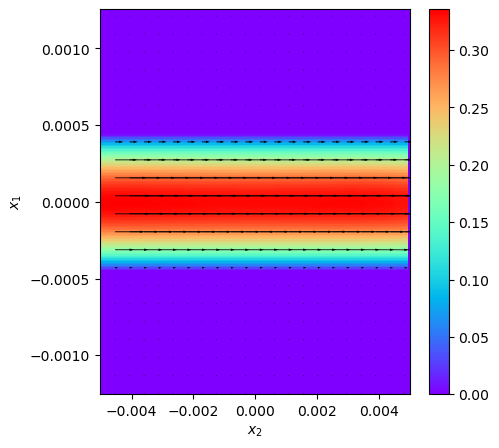

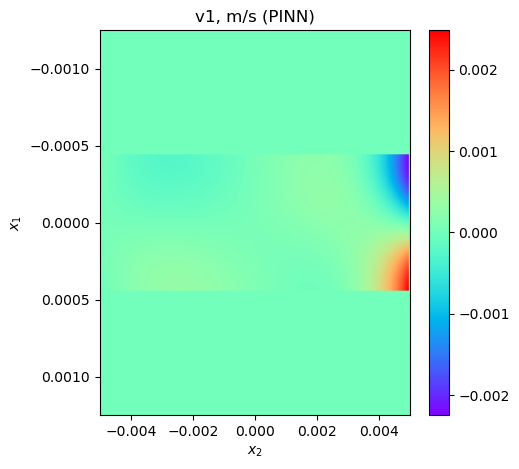

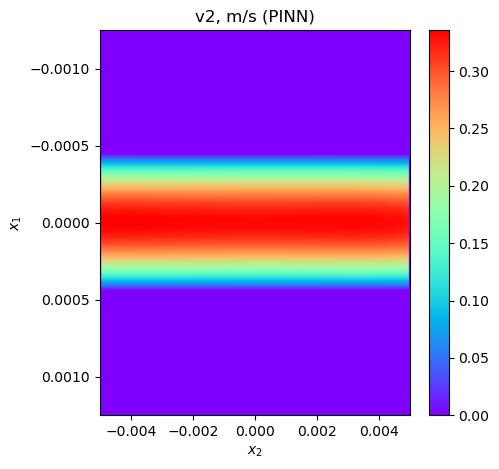

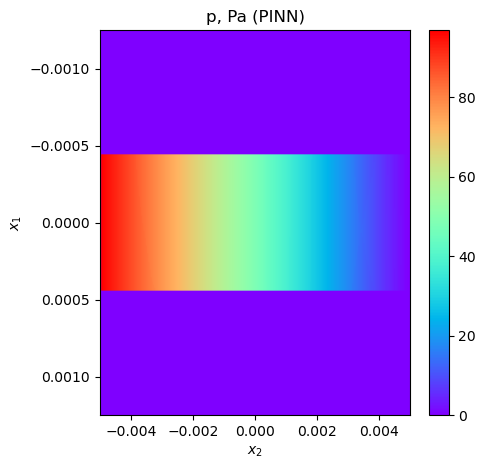

ID1: -163.04261779785156, ID2: -201.76312255859375, weight: 86.1082763671875
v_abs: 0.6615526271703914
p_max: 52.483673095703125


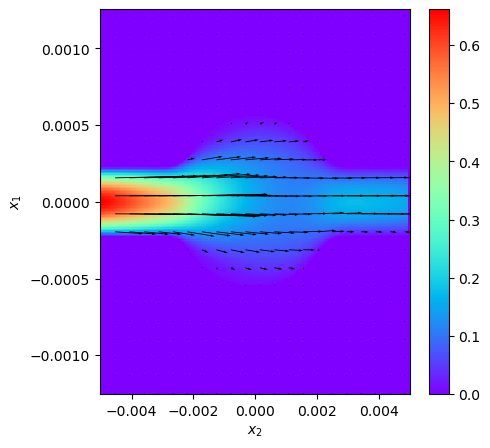

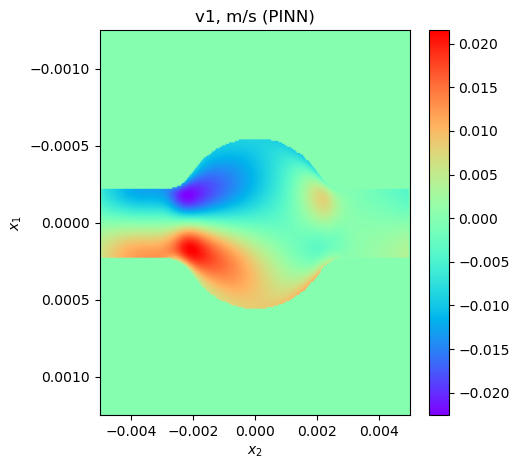

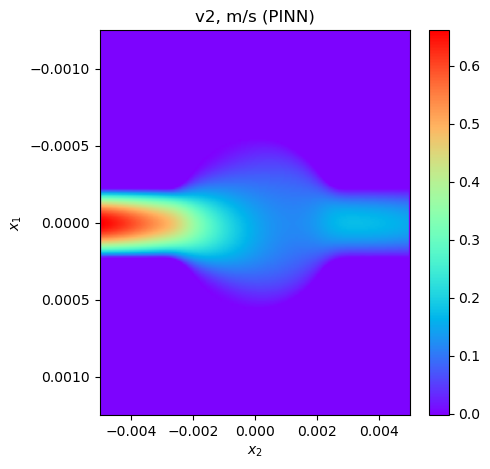

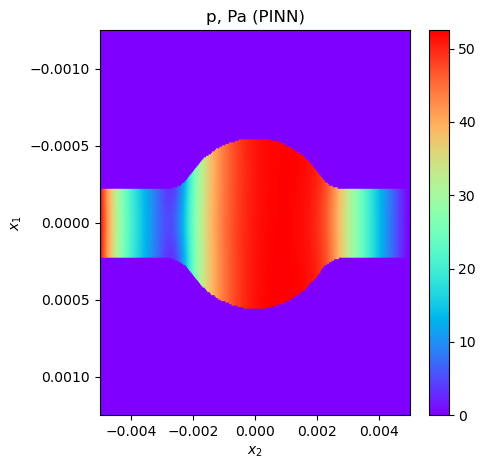

ID1: 108.98348999023438, ID2: 147.58717346191406, weight: -25.083528518676758
v_abs: 0.3731527486701147
p_max: 115.27801513671875


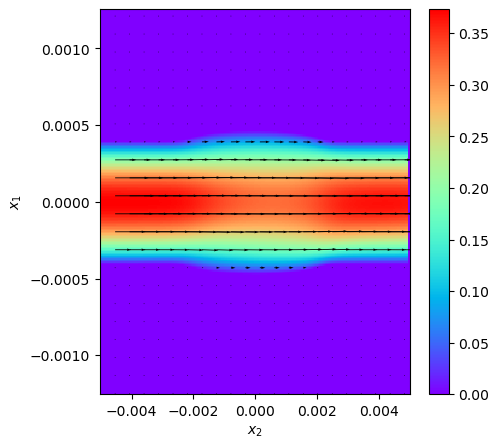

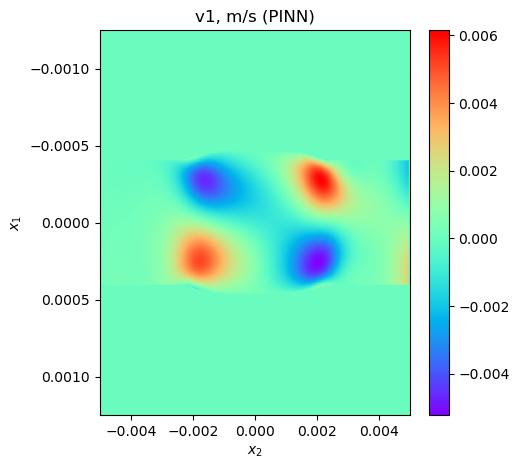

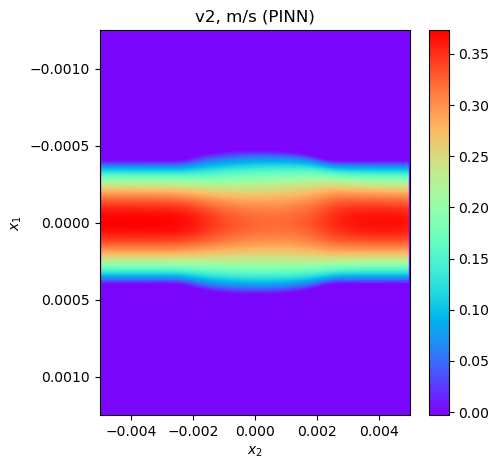

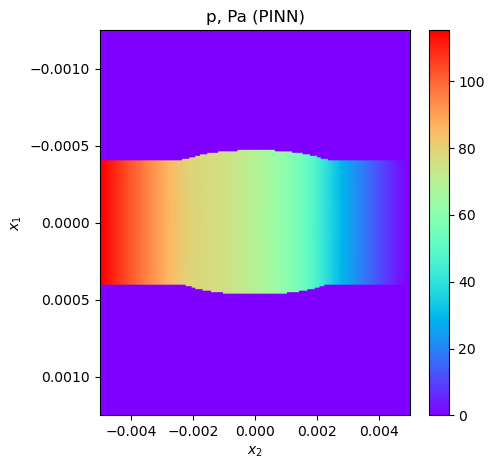

ID1: 49.20414352416992, ID2: 51.67904281616211, weight: -23.773609161376953
v_abs: 0.419737558496986
p_max: 136.54397583007812


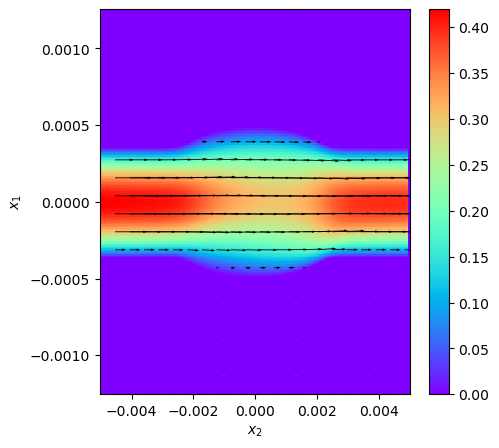

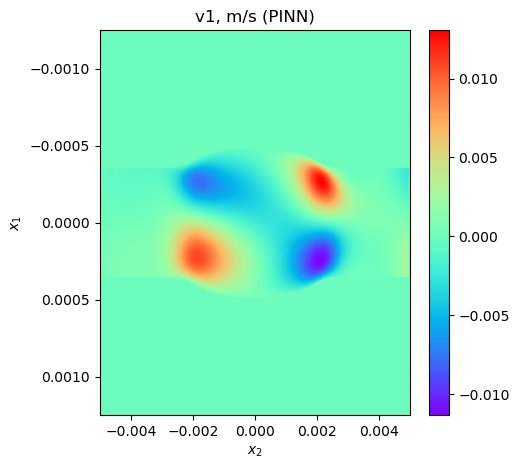

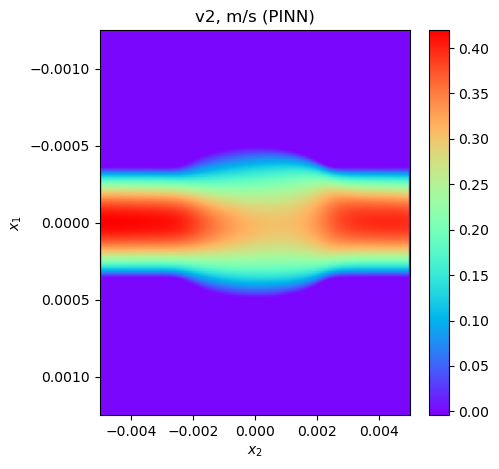

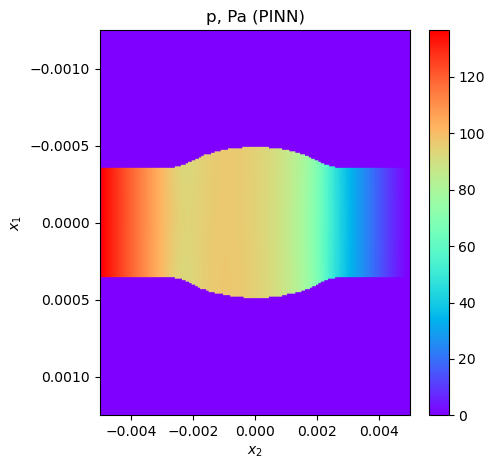

ID1: -16.06434440612793, ID2: -27.644424438476562, weight: 9.252955436706543
v_abs: 0.4763653479735758
p_max: 149.9274139404297


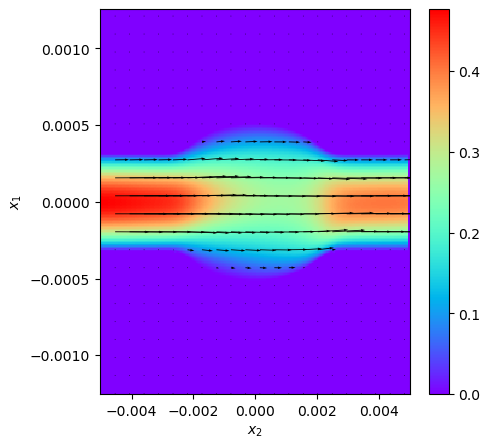

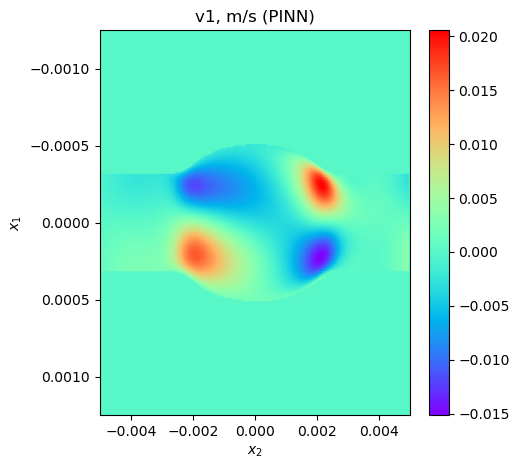

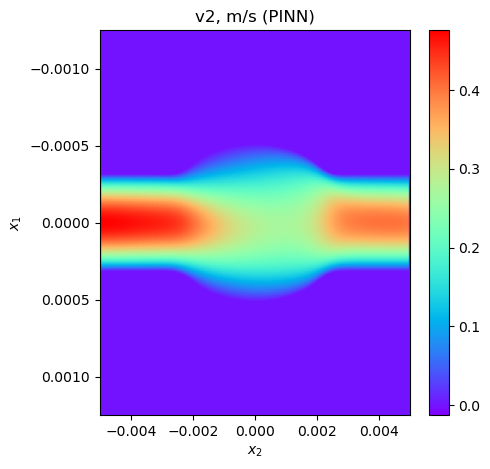

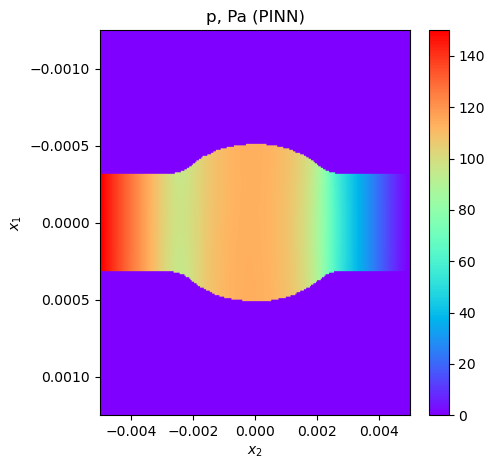

ID1: -73.0899658203125, ID2: -102.78009796142578, weight: 32.65404510498047
v_abs: 0.5537757041990051
p_max: 136.5221405029297


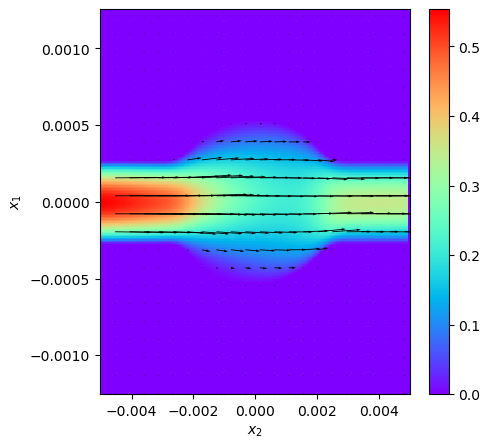

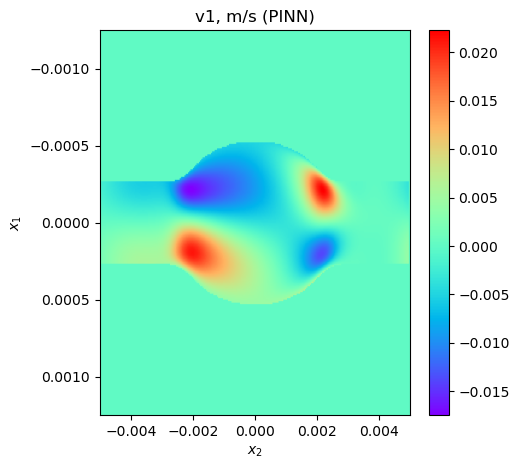

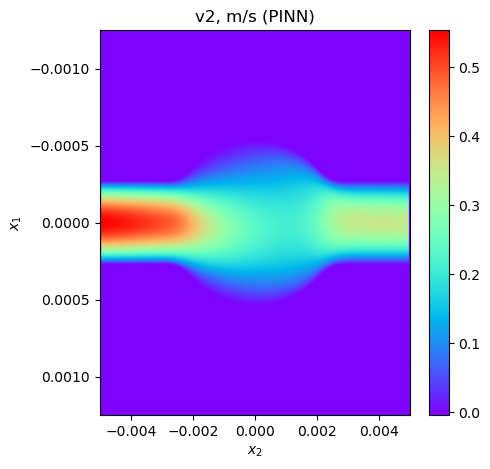

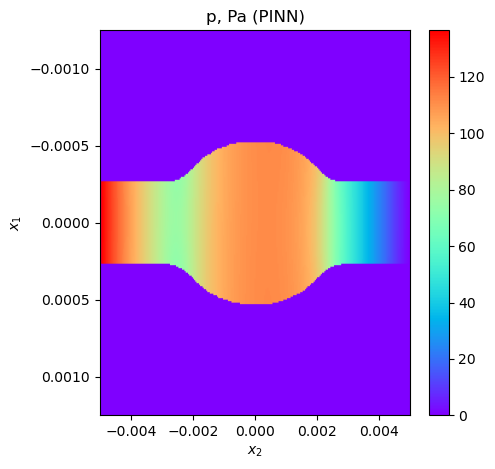

In [22]:
visualization(train_loader, 'Train')

## Visualize val dataset

Train visualization
ID1: 134.3624725341797, ID2: 196.8229522705078, weight: -13.159405708312988
v_abs: 0.3520242807738581
p_max: 102.12185668945312


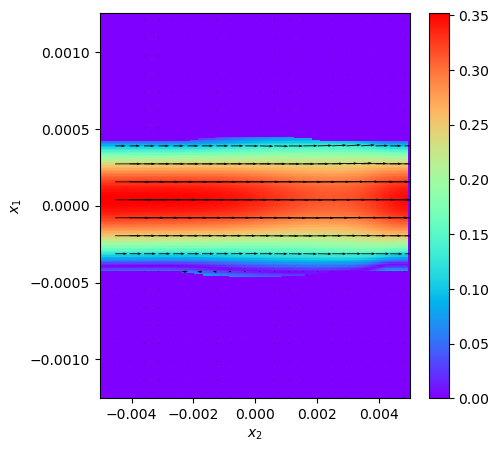

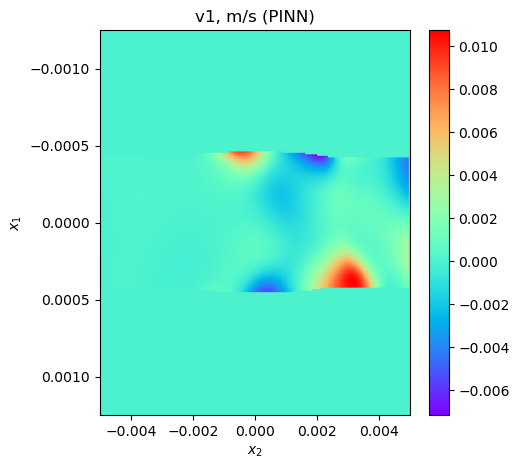

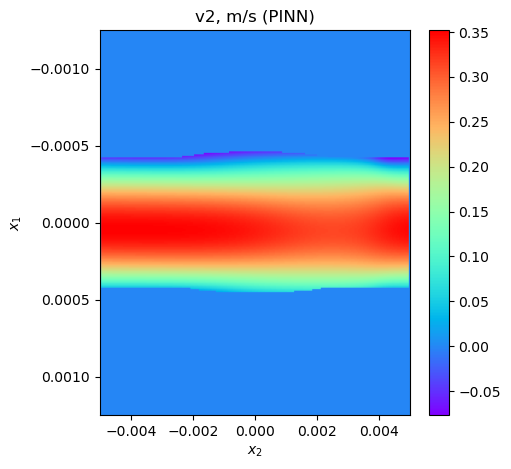

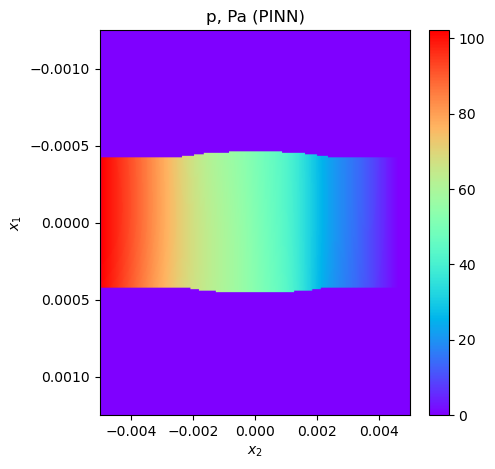

ID1: 80.77958679199219, ID2: 97.6318130493164, weight: -30.519861221313477
v_abs: 0.3998964179672069
p_max: 131.68287658691406


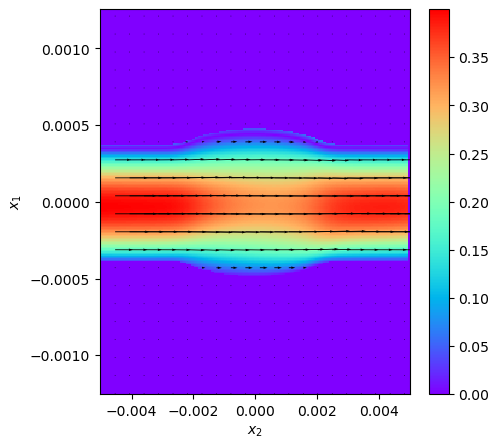

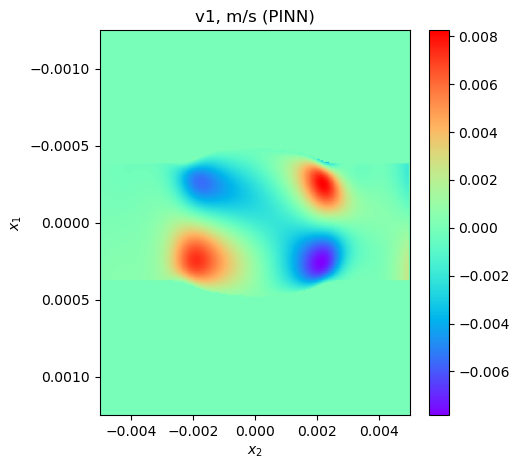

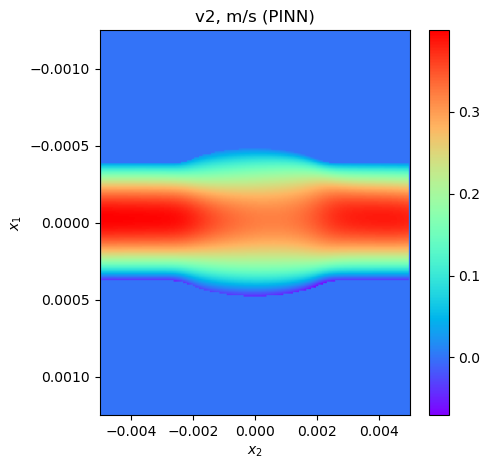

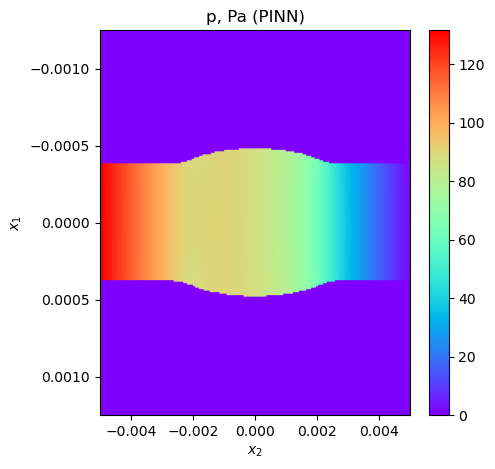

ID1: 14.936965942382812, ID2: 8.523681640625, weight: -8.104413032531738
v_abs: 0.423204146095434
p_max: 144.87571716308594


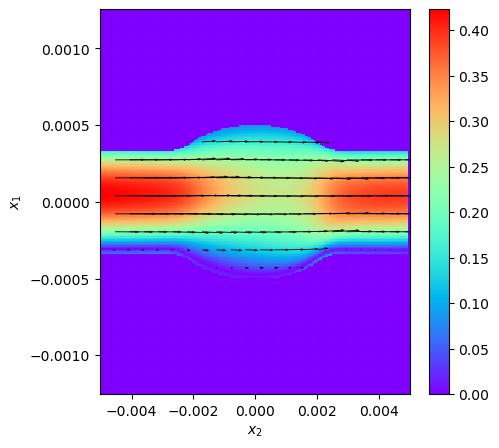

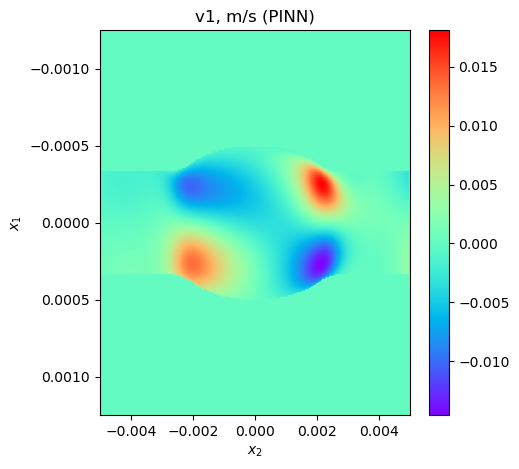

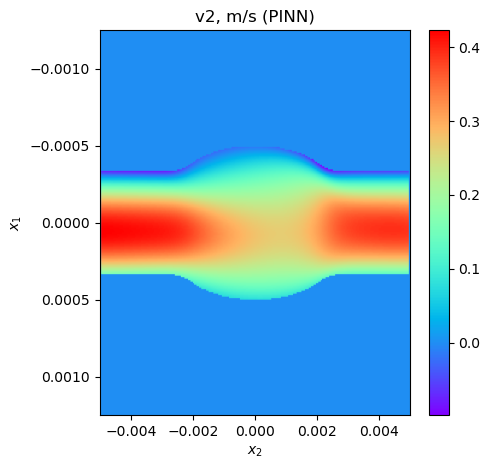

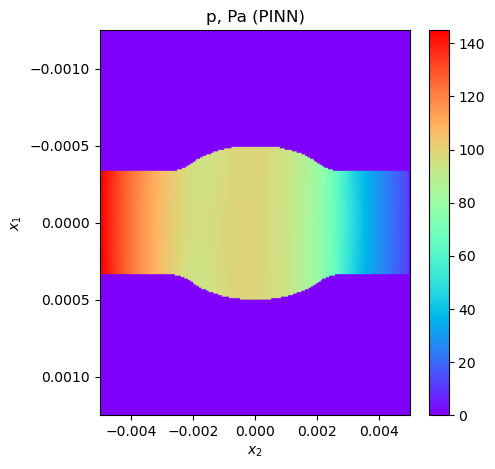

ID1: -43.356109619140625, ID2: -64.42868041992188, weight: 20.894201278686523
v_abs: 0.5173497200746476
p_max: 114.06810760498047


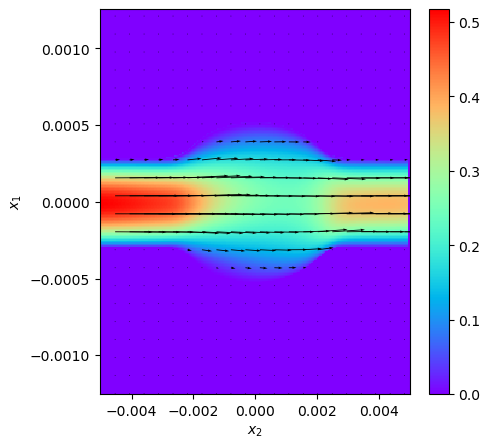

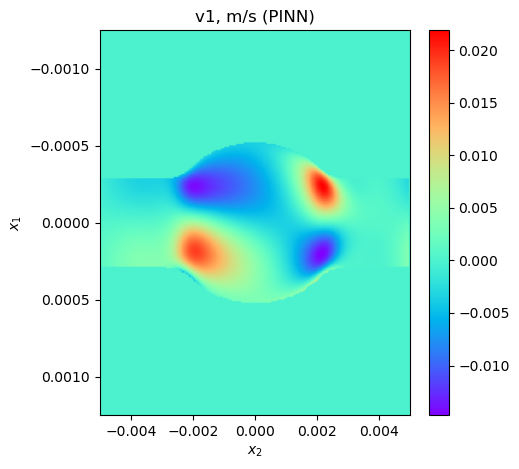

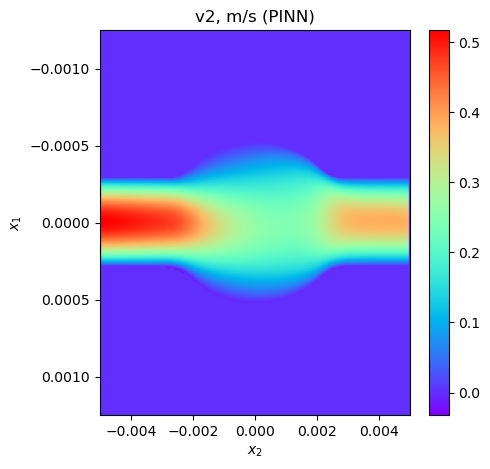

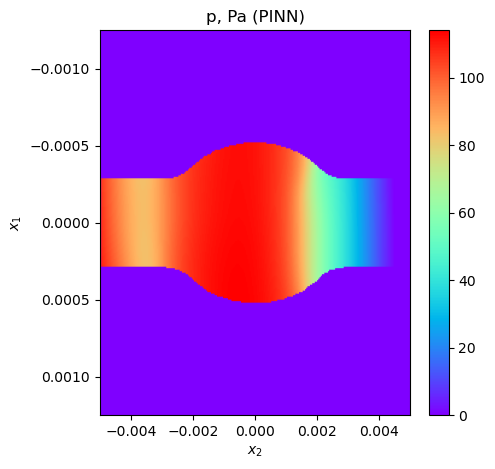

ID1: -108.36711120605469, ID2: -143.1382598876953, weight: 49.79831314086914
v_abs: 0.6080723317262192
p_max: 88.83808898925781


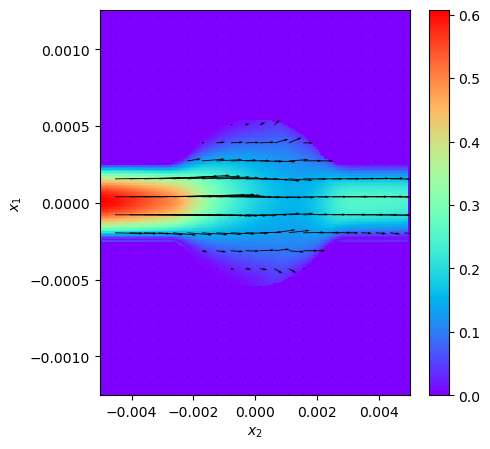

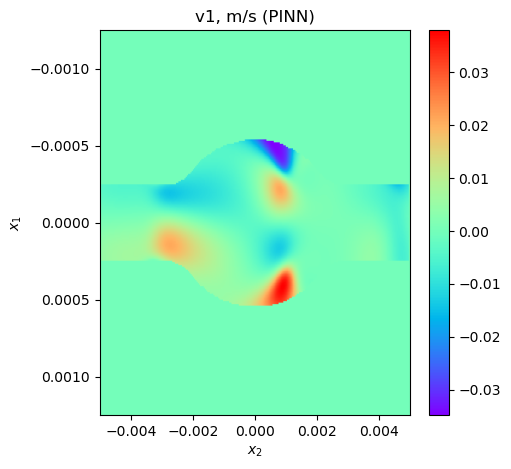

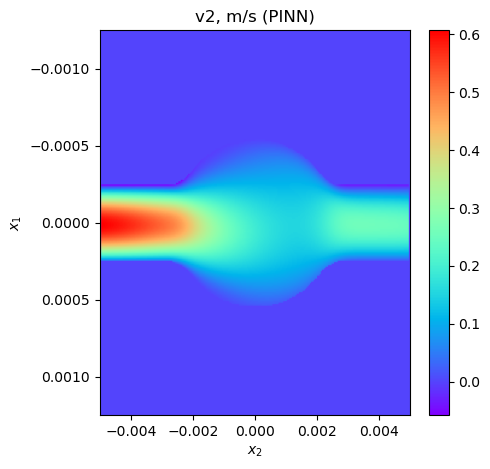

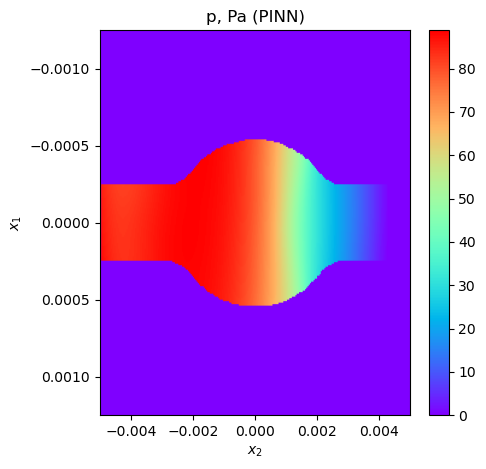

In [23]:
visualization(val_loader, 'Train')

In [24]:
# plt.scatter(*train_dataset[2][1].T.cpu(), s=2)
# plt.scatter(*train_dataset[2][2][:, 2:].T.cpu(), s=2)

In [25]:
# mini_dataset = ClassDataset('mini_dataset', encoder)

In [26]:
# loader = DataLoader(mini_dataset, batch_size=1, shuffle=True)

In [27]:
# plt.figure(figsize=(10,50))
# i=1
# for emb_interior, x_interior, inputs_boundary, mask_, center, h in loader:
#     plt.subplot(11,1,i)
#     plt.title(f"Latent Vector ({LATENT_DIM} dim)")
#     latent_vector = emb_interior[0].cpu().numpy()
#     colors = ['r' if v < 0 else 'b' for v in latent_vector[0]]
#     plt.bar(range(LATENT_DIM), latent_vector[0], color=colors)
#     plt.xlabel("Dimension Index")
#     plt.ylabel("Value")
#     plt.grid(True, alpha=0.3)
#     i+=1

# plt.show()

In [28]:
# plt.figure(figsize=(10,250))
# img_features = np.zeros((128,11))
# i=0
# for emb_interior, x_interior, inputs_boundary, mask_, center, h in loader:
#     latent_vector = emb_interior[0].cpu().numpy()
#     img_features[:,i] = latent_vector[0]
#     i+=1

# for j in range(128):
#     plt.subplot(128,1,j+1)
#     plt.title(f"Feature interpolation (11 img)")
#     colors = ['r' if v < 0 else 'b' for v in img_features[j]]
#     plt.bar(range(11), img_features[j], color=colors)
#     plt.xlabel("image")
#     plt.ylabel("Value")
#     plt.grid(True, alpha=0.3)
#     i+=1

# plt.show()

# Compare with CFD

In [29]:
def distribution_visualization_all(targets, outputs, errors, mask_, ref_1, ref_2, interp):
     v1_tar = (targets[..., 0].reshape(N, N)) * mask_
     v2_tar = (targets[..., 1].reshape(N, N)) * mask_
     p_tar = (targets[..., 2].reshape(N, N)) * mask_

     v1_pred = (outputs[..., 0].reshape(N, N)) * mask_
     v2_pred = (outputs[..., 1].reshape(N, N)) * mask_
     p_pred = (outputs[..., 2].reshape(N, N)) * mask_

     v1_err = (errors[..., 0].reshape(N, N)) * mask_
     v2_err = (errors[..., 1].reshape(N, N)) * mask_
     p_err = (errors[..., 2].reshape(N, N)) * mask_
     
     fig, ax = plt.subplots(figsize=(vis.PARAMS['figsize'] * 2, vis.PARAMS['figsize'] * 2), nrows=3, ncols=3)

     vis.imshow(fig, ax[0, 0], v1_tar * 100, vis.PARAMS['L1'] * 1000, vis.PARAMS['L2'] * 1000, r'$x_1, $mm', r'$x_2, $mm', r'$v_1^{CFD}, $cm/s')
     vis.imshow(fig, ax[0, 1], v1_pred * 100, vis.PARAMS['L1'] * 1000, vis.PARAMS['L2'] * 1000, r'$x_1, $mm', r'$x_2, $mm', r'$v_1^{PINN}, $cm/s')
     vis.imshow(fig, ax[0, 2], v1_err * 100, vis.PARAMS['L1'] * 1000, vis.PARAMS['L2'] * 1000, r'$x_1, $mm', r'$x_2, $mm', r'$v_1^{Error}, $cm/s')

     vis.imshow(fig, ax[1, 0], v2_tar * 100, vis.PARAMS['L1'] * 1000, vis.PARAMS['L2'] * 1000, r'$x_1, $mm', r'$x_2, $mm', r'$v_2^{CFD}, $cm/s')
     vis.imshow(fig, ax[1, 1], v2_pred * 100, vis.PARAMS['L1'] * 1000, vis.PARAMS['L2'] * 1000, r'$x_1, $mm', r'$x_2, $mm', r'$v_2^{PINN}, $cm/s')
     vis.imshow(fig, ax[1, 2], v2_err * 100, vis.PARAMS['L1'] * 1000, vis.PARAMS['L2'] * 1000, r'$x_1, $mm', r'$x_2, $mm', r'$v_2^{Error}, $cm/s')

     vis.imshow(fig, ax[2, 0], p_tar, vis.PARAMS['L1'] * 1000, vis.PARAMS['L2'] * 1000, r'$x_1, $mm', r'$x_2, $mm', r'$p^{CFD}, $Pa')
     vis.imshow(fig, ax[2, 1], p_pred, vis.PARAMS['L1'] * 1000, vis.PARAMS['L2'] * 1000, r'$x_1, $mm', r'$x_2, $mm', r'$p^{PINN}, $Pa')
     vis.imshow(fig, ax[2, 2], p_err, vis.PARAMS['L1'] * 1000, vis.PARAMS['L2'] * 1000, r'$x_1, $mm', r'$x_2, $mm', r'$p^{Error}, $Pa')

     plt.subplots_adjust(hspace=0.35, wspace=0.4)

     plt.savefig(f'{ref_1}_{ref_2}_{interp}.png', transparent=True)

     plt.show()

In [30]:
def visualization_compare(ref_1, ref_2, interp, inputs, targets, outputs, mask_, emb):
    knn_tar = KNeighborsRegressor(3, weights='distance')
    knn_pred = KNeighborsRegressor(3, weights='distance')
    knn_err = KNeighborsRegressor(3, weights='distance')
    # knn_tar.fit(inputs[:, 3:], targets)
    # knn_pred.fit(inputs[:, 3:], outputs)
    # knn_err.fit(inputs[:, 3:], outputs - targets)
    knn_tar.fit(inputs[:, 128:], targets)
    knn_pred.fit(inputs[:, 128:], outputs)
    knn_err.fit(inputs[:, 128:], outputs - targets)

    
    with torch.no_grad():
        x1 = torch.linspace(-L1 / 2, L1 / 2, N)
        x2 = torch.linspace(-L2 / 2, L2 / 2, N)
        x1, x2 = torch.meshgrid((x1, x2))
        x = torch.stack((x1.flatten(0), x2.flatten(0)), 1).to(DEVICE)
        emb = torch.Tensor(emb).to(DEVICE)
        inputs = torch.cat((emb.repeat(1, N * N, 1), x.to(DEVICE).unsqueeze(0)), 2)
        outputs = model(inputs)
        # targets = knn_tar.predict(inputs.cpu().numpy()[0, :, 3:])
        # outputs = knn_pred.predict(inputs.cpu().numpy()[0, :, 3:])
        # errors = knn_err.predict(inputs.cpu().numpy()[0, :, 3:])
        targets = knn_tar.predict(inputs.cpu().numpy()[0, :, 128:])
        outputs = knn_pred.predict(inputs.cpu().numpy()[0, :, 128:])
        errors = knn_err.predict(inputs.cpu().numpy()[0, :, 128:])

        v1_tar = (targets[..., 0].reshape(N, N)) * mask_
        v2_tar = (targets[..., 1].reshape(N, N)) * mask_
        v1_pred = (outputs[..., 0].reshape(N, N)) * mask_
        v2_pred = (outputs[..., 1].reshape(N, N)) * mask_
        plt.imshow(mask_)
        plt.show()
        vis.flow_visualization(v1_tar, v2_tar, x1, x2)
        vis.flow_visualization(v1_pred, v2_pred, x1, x2)

        distribution_visualization_all(targets, outputs, errors, mask_, ref_1, ref_2, interp)


In [31]:
def mae(targets, outputs, inputs):
    v_abs_tar = 100 * (targets[:, :2] ** 2).sum(1) ** 0.5
    v_abs_pred = 100 * (outputs[:, :2] ** 2).sum(1) ** 0.5

    p_tar = targets[:, -1]
    p_pred = outputs[:, -1]

    error_v = abs(v_abs_pred - v_abs_tar).mean()
    error_p = abs(outputs[:, -1] - targets[:, -1]).mean()

    mean_error_v = abs(v_abs_pred.mean() - v_abs_tar.mean()) / v_abs_tar.mean()
    mean_error_p = abs(p_pred.mean() - p_tar.mean()) / p_tar.mean()

    return error_v, mean_error_v * 100, v_abs_tar.max(), error_p, mean_error_p * 100, p_tar.max()

mini_train
1.0 5.0 0.0
error_v 7.979546861564187 mean_error_v 29.840125050778667 v_max 22.94440000008449 error_p 31.782577017641934 mean_error_p 198.62830012264422 p_max 33.83562


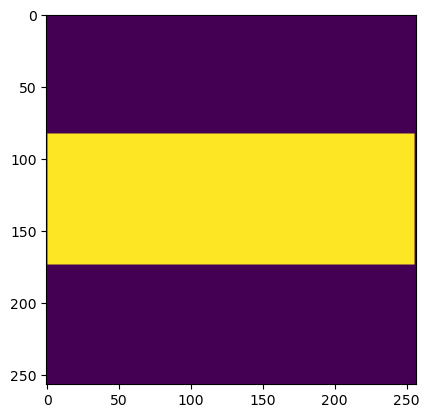

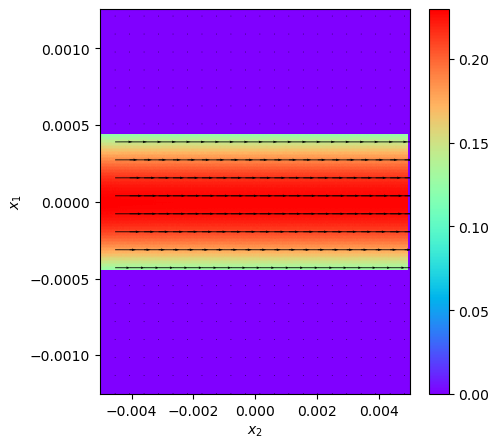

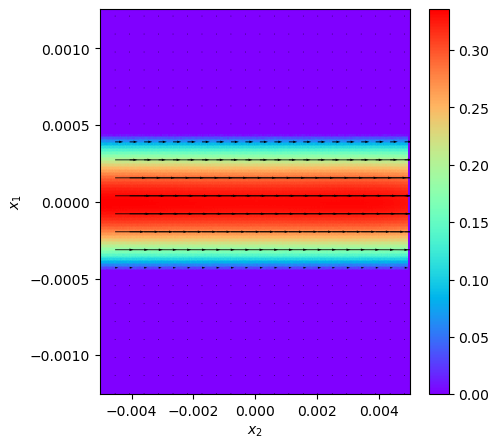

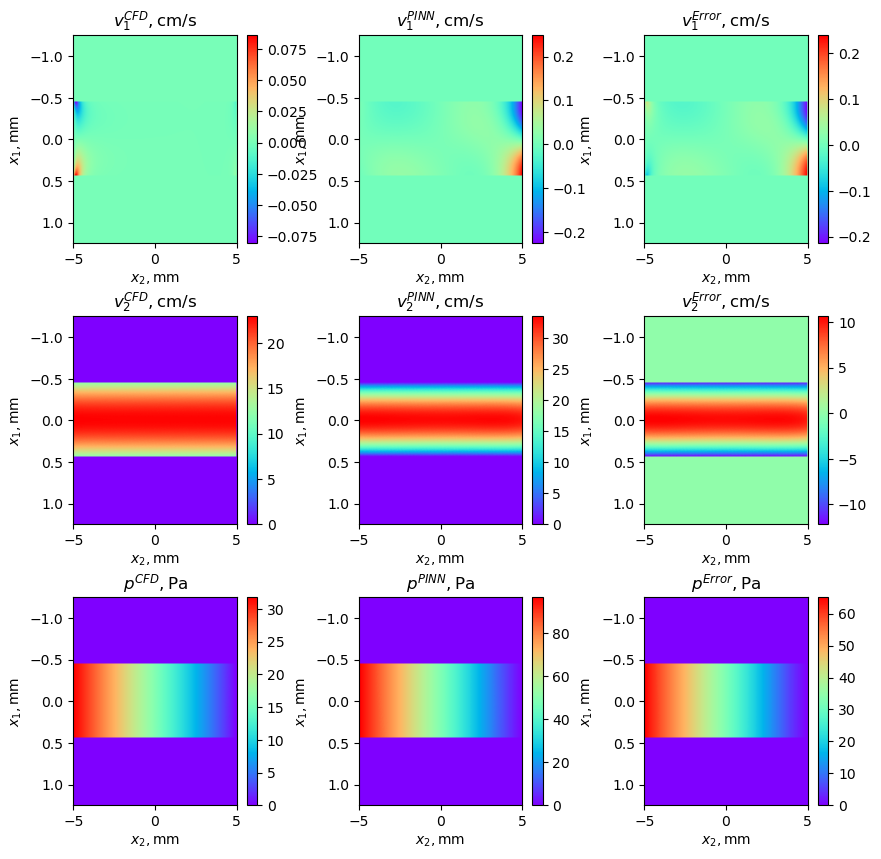

1.0 5.0 100.0
error_v 10.454011985626543 mean_error_v 32.36006296459338 v_max 45.4386 error_p 69.94530758963724 mean_error_p 65.58508507044229 p_max 160.17120000000003


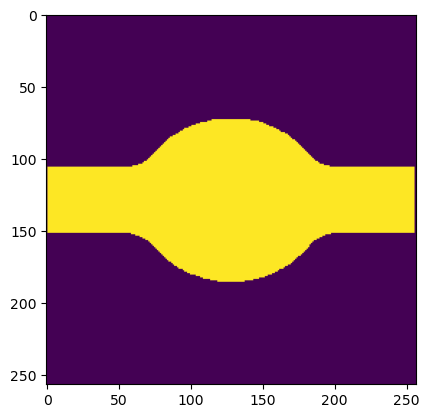

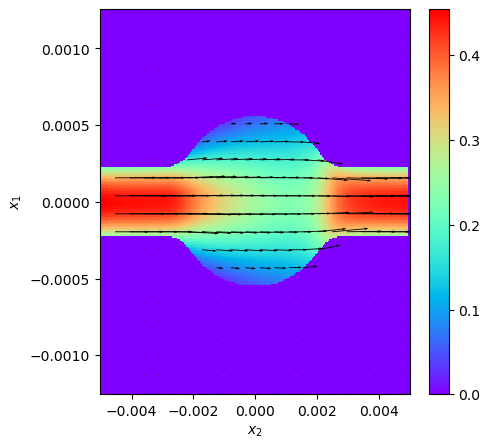

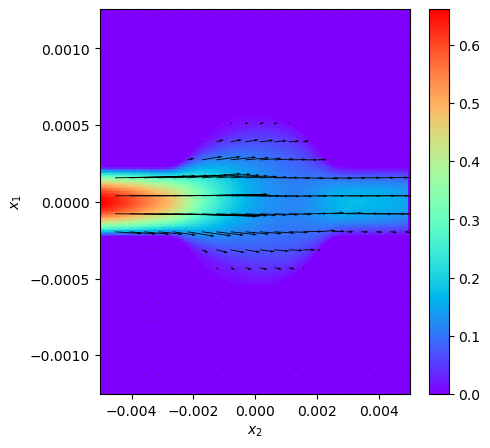

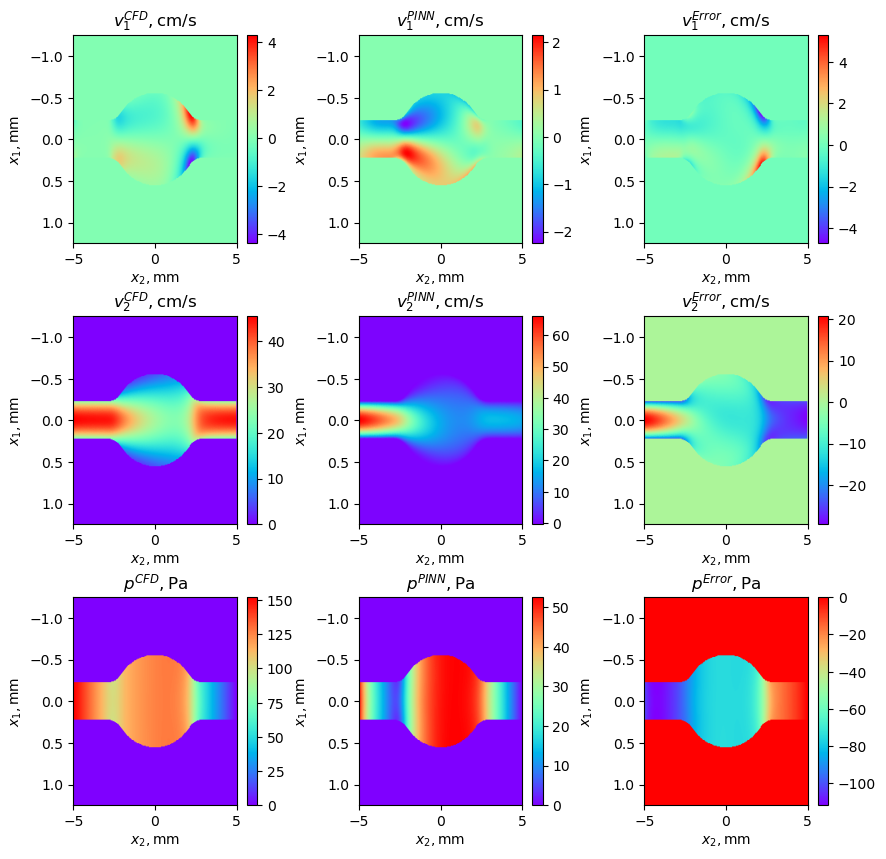

1.0 5.0 20.0
error_v 8.557060696601804 mean_error_v 30.969329738886493 v_max 25.5214 error_p 40.7804721492842 mean_error_p 191.76005461498826 p_max 40.042275000000004


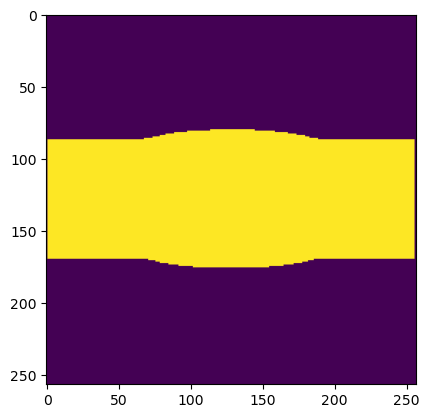

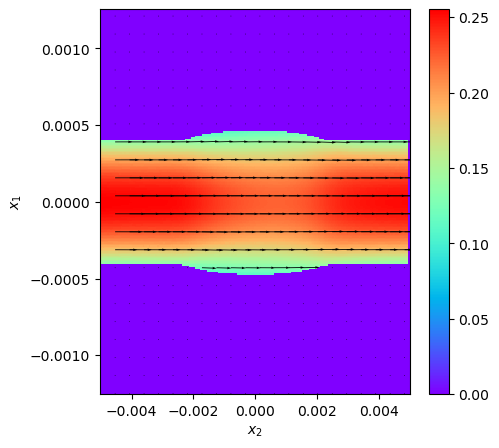

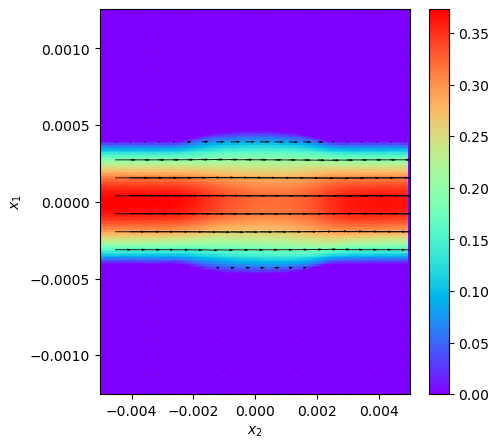

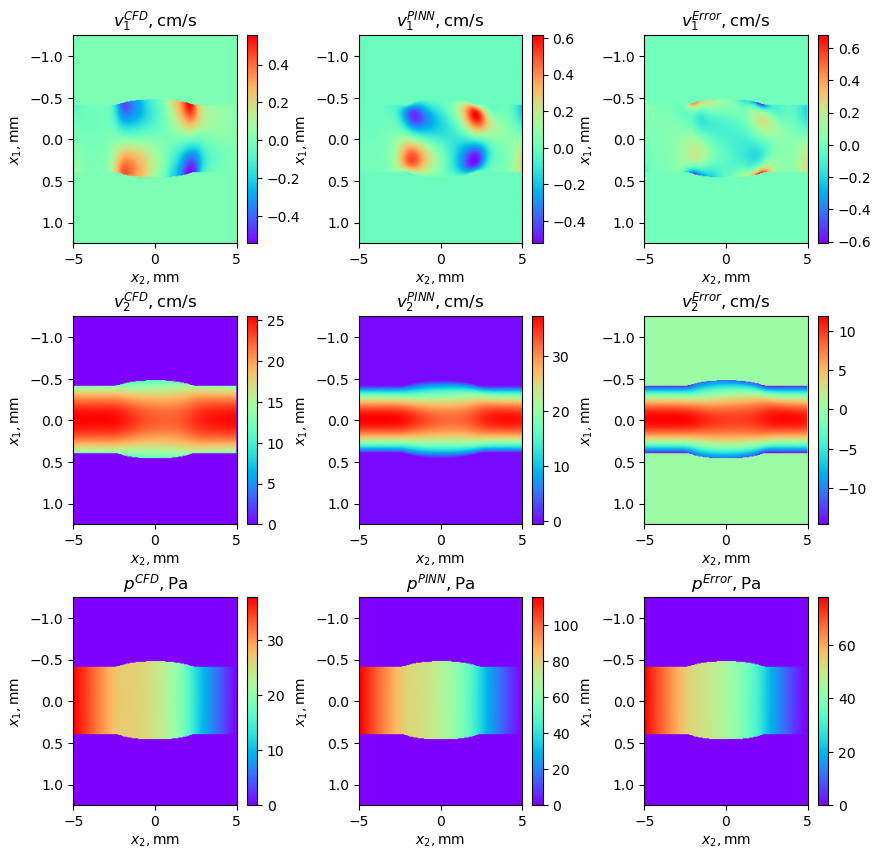

1.0 5.0 40.0
error_v 8.437248591402266 mean_error_v 26.859430106739573 v_max 28.63370000130446 error_p 50.14695282231965 mean_error_p 170.1302517254501 p_max 50.50542


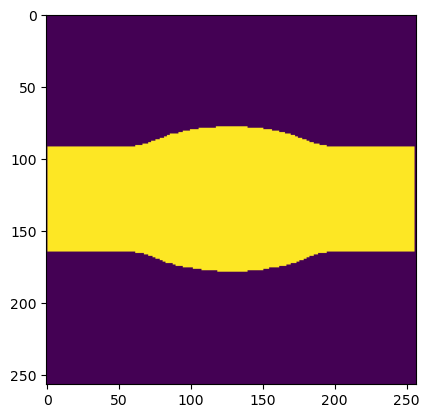

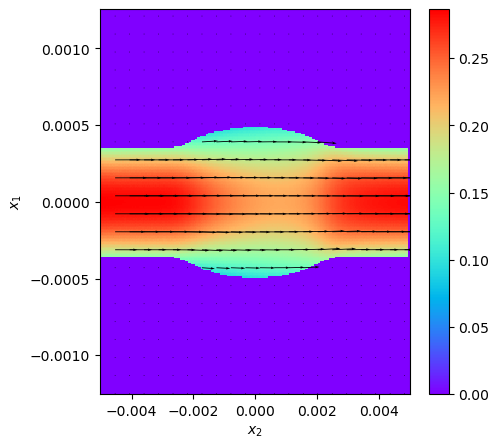

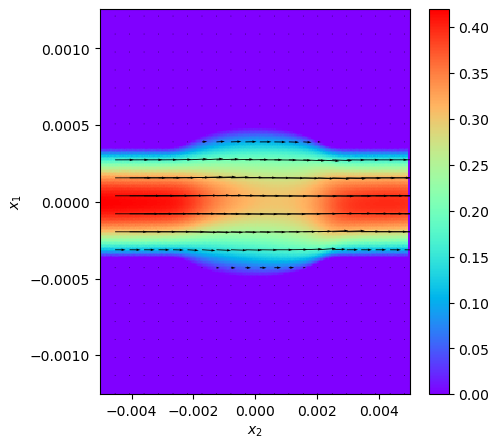

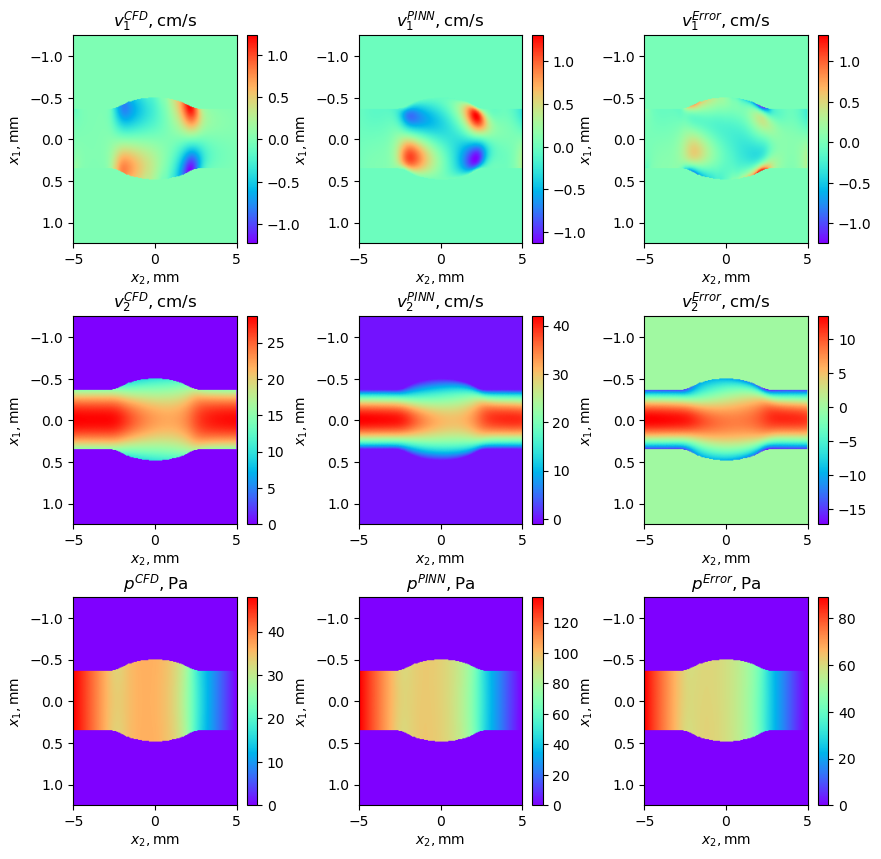

1.0 5.0 60.0
error_v 7.611182197038736 mean_error_v 17.065100543542382 v_max 32.459700000000005 error_p 50.8069971423992 mean_error_p 120.93071960740305 p_max 68.074125


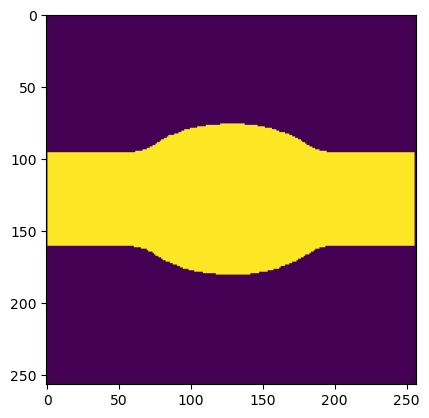

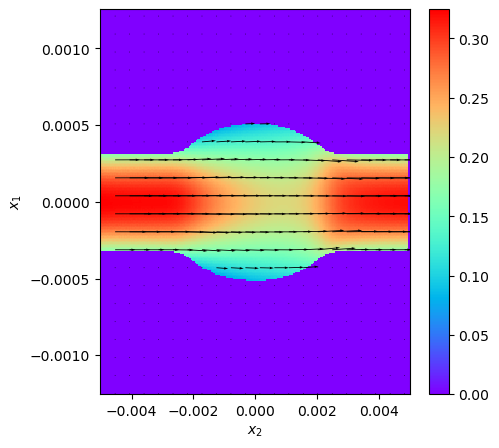

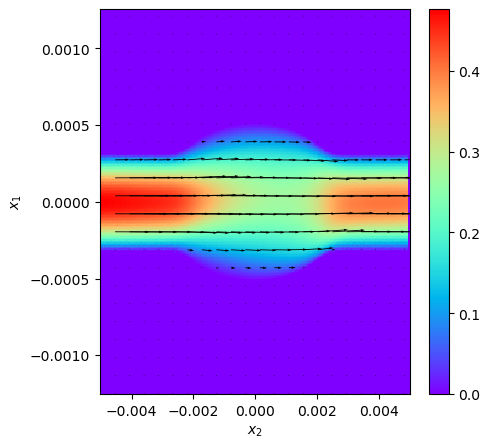

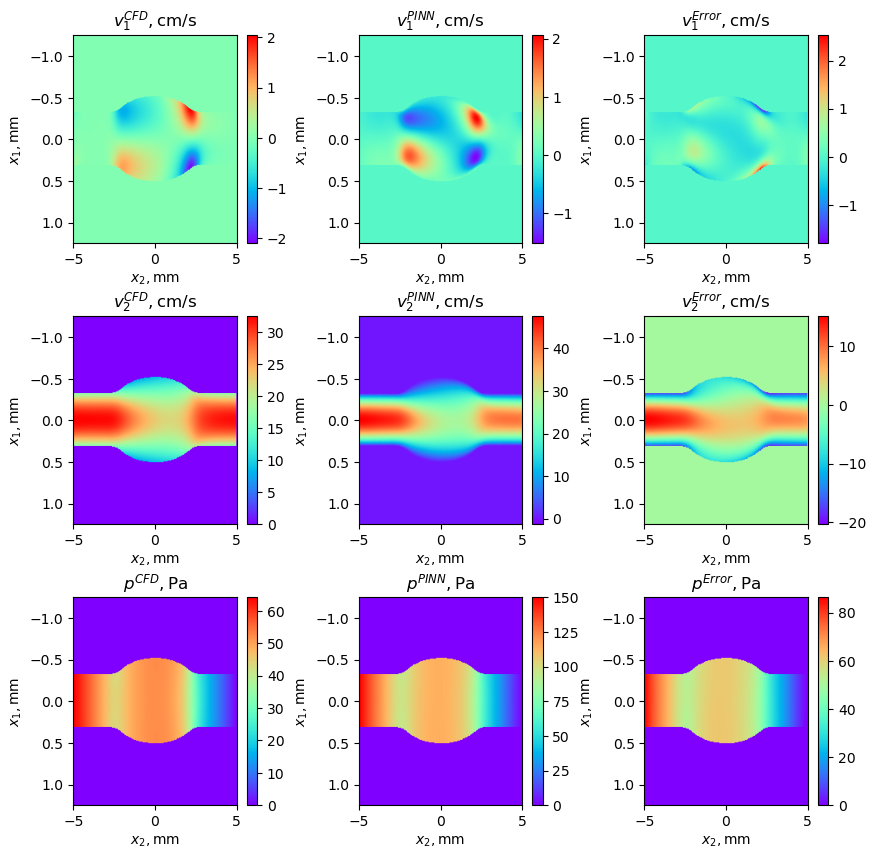

1.0 5.0 80.0
error_v 6.948249710651274 mean_error_v 1.840338095083647 v_max 38.0709 error_p 24.21573512713571 mean_error_p 37.095108030752534 p_max 98.94045


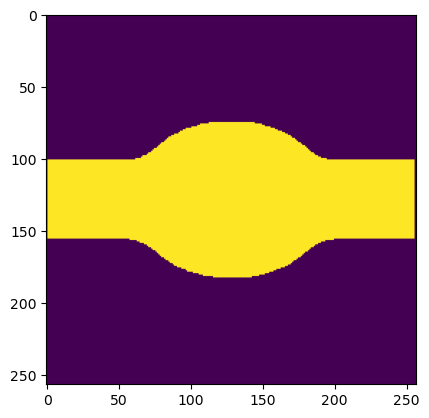

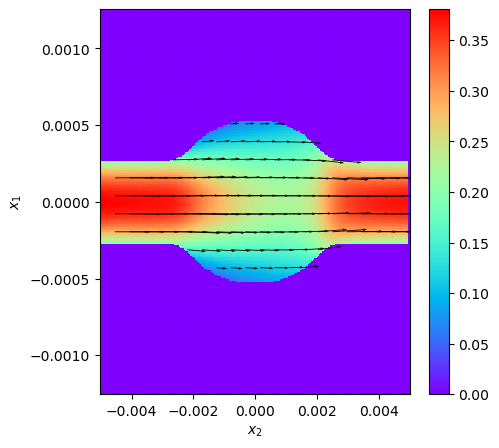

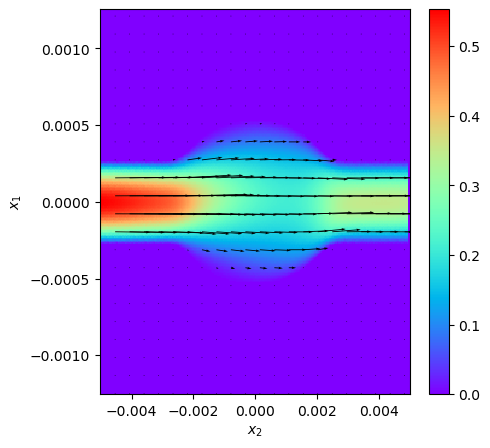

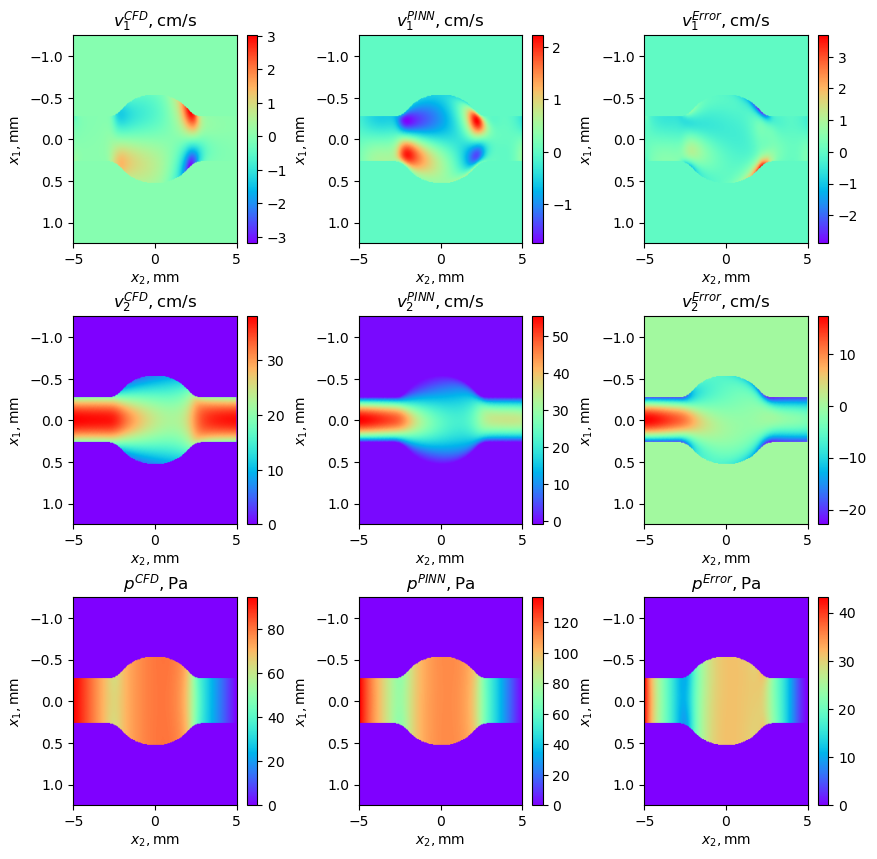

mini_val
1.0 5.0 10.0
error_v 8.078059388121979 mean_error_v 28.956277663845448 v_max 24.12230000028238 error_p 30.943435272545074 mean_error_p 169.0786456545605 p_max 36.245265


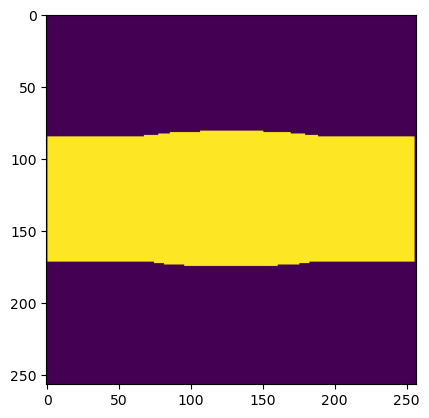

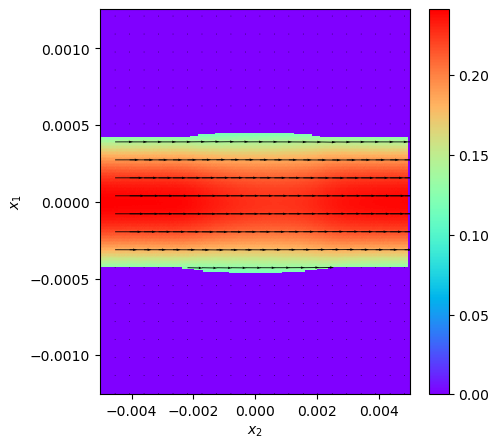

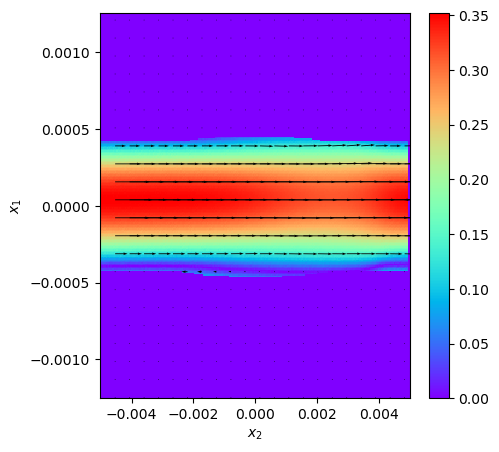

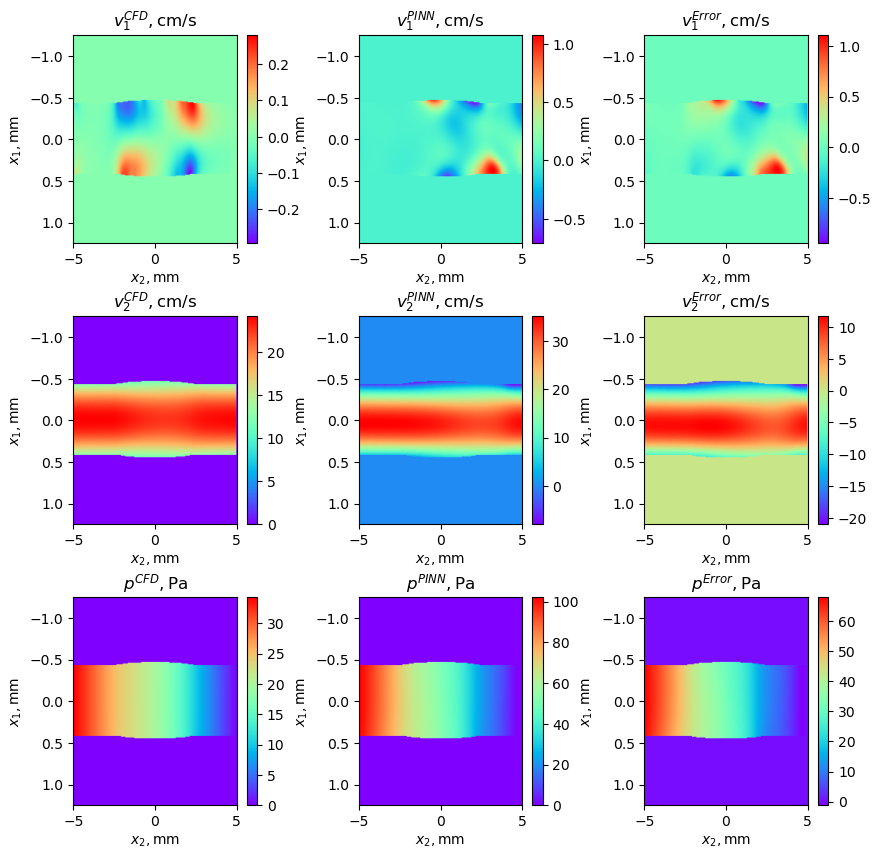

1.0 5.0 30.0
error_v 8.878634993151536 mean_error_v 30.818269842012192 v_max 26.986800487877353 error_p 50.32476896673826 mean_error_p 203.1201623995848 p_max 44.85096


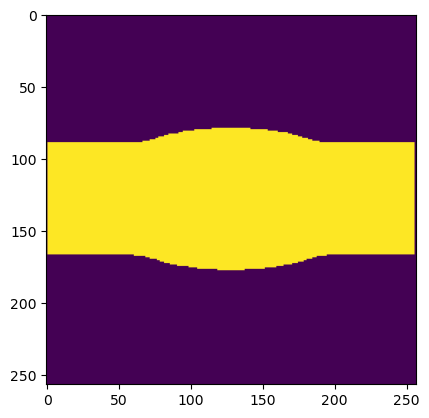

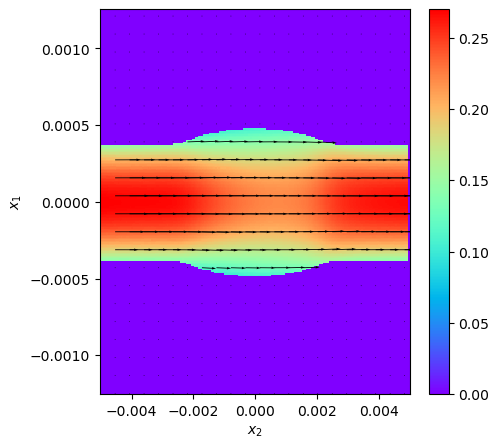

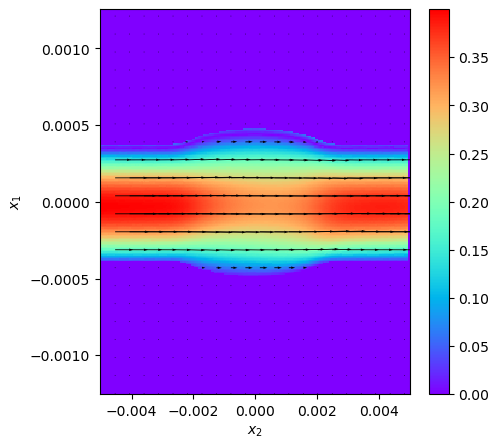

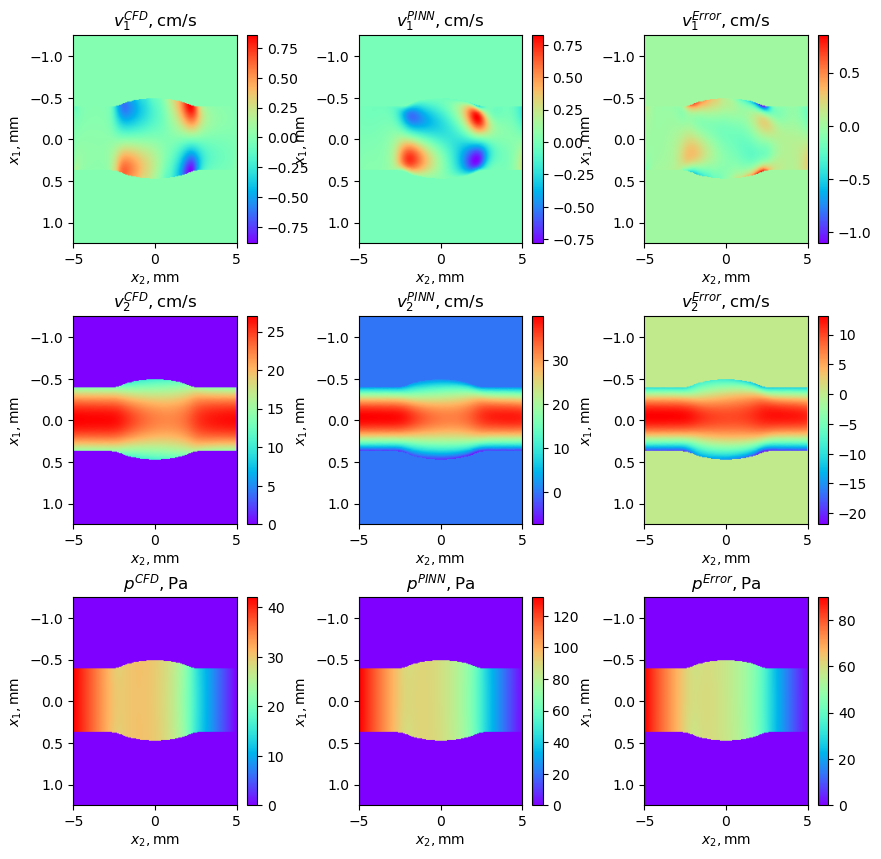

1.0 5.0 50.0
error_v 7.2206083079660095 mean_error_v 18.595781498444154 v_max 30.490800019309223 error_p 51.781801922050704 mean_error_p 147.9769868613786 p_max 58.35228


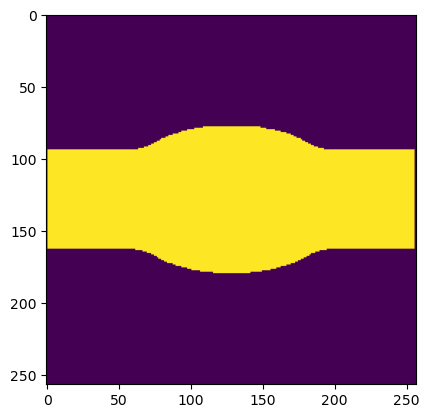

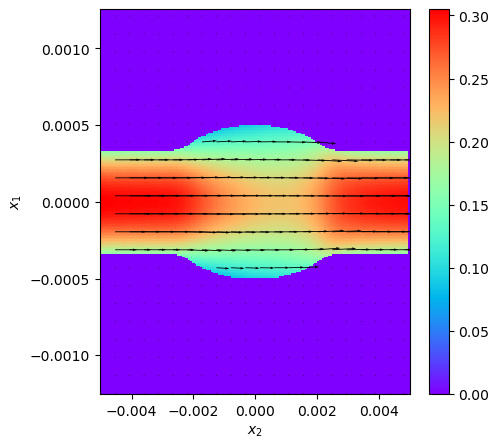

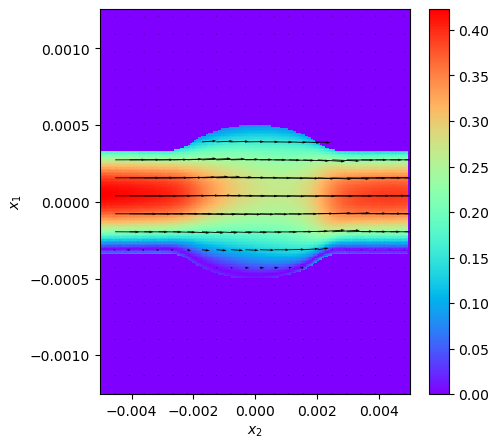

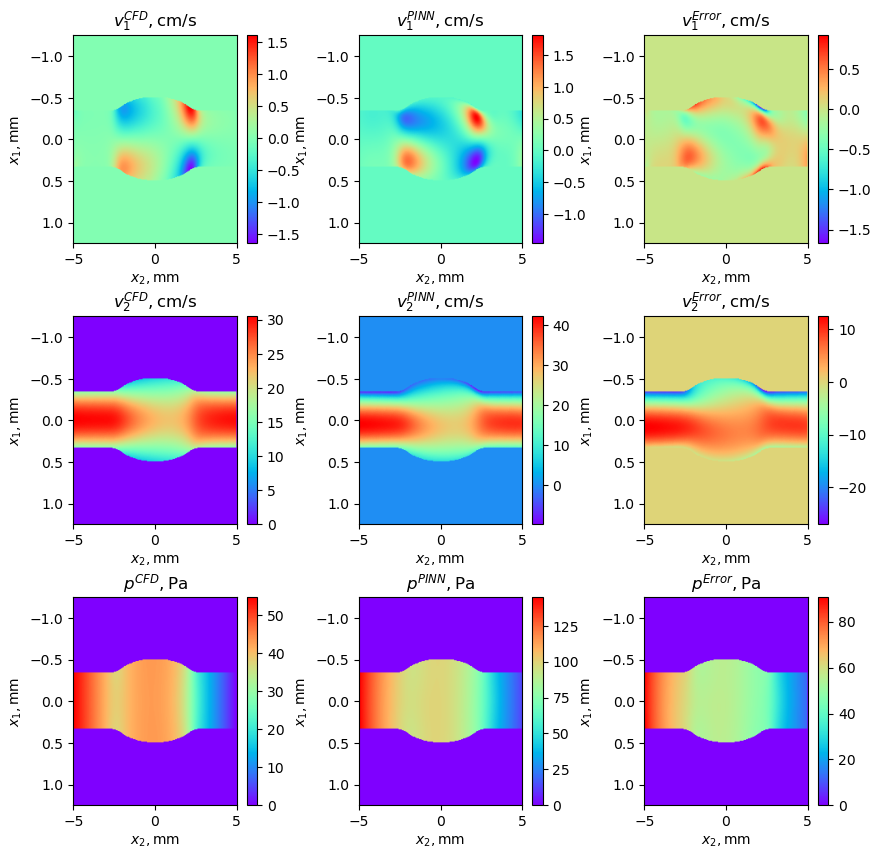

1.0 5.0 70.0
error_v 7.035240624334009 mean_error_v 8.423192258739055 v_max 35.04300004838253 error_p 31.756793273759214 mean_error_p 59.89604889275222 p_max 82.293015


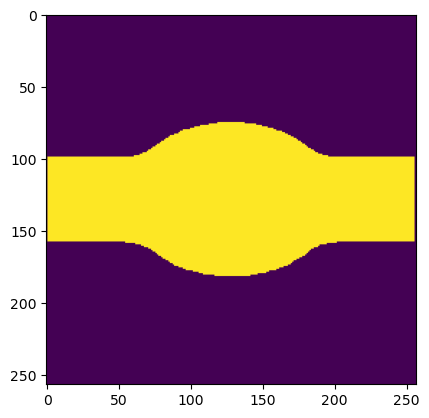

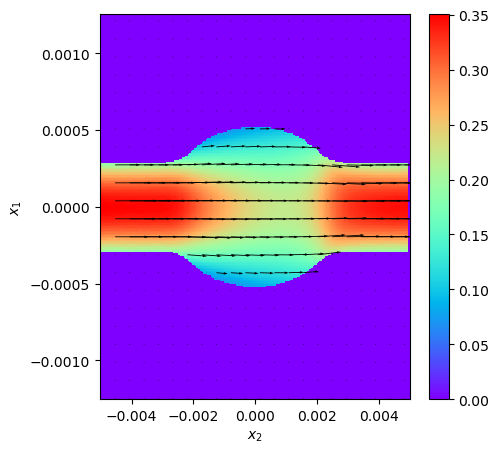

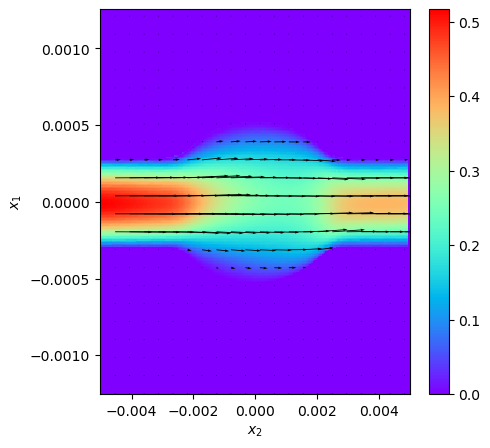

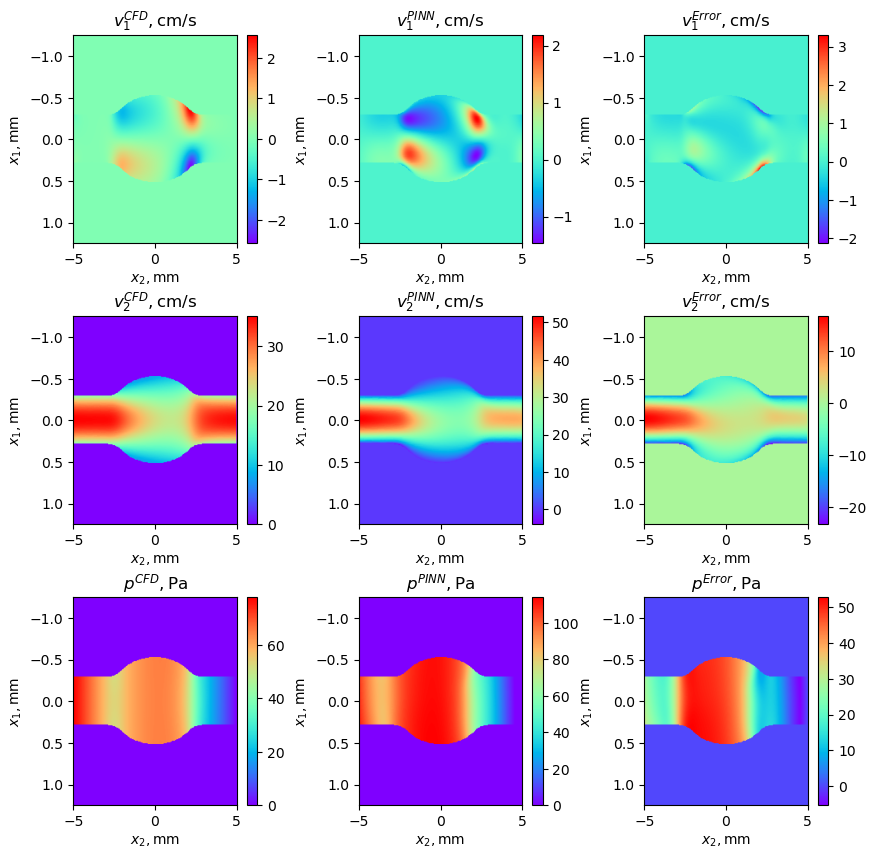

1.0 5.0 90.0
error_v 8.767936005976068 mean_error_v 17.794554846556196 v_max 41.1873 error_p 21.397273603466193 mean_error_p 24.495110895422027 p_max 125.53905


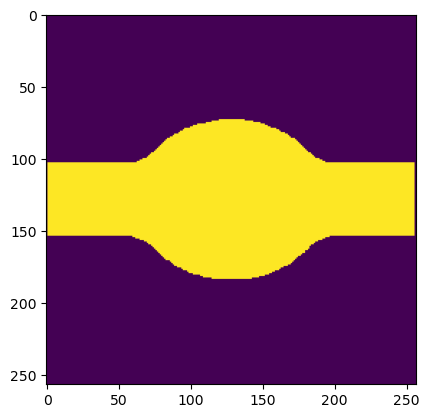

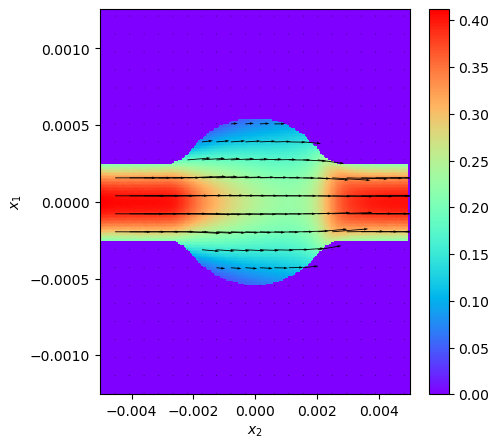

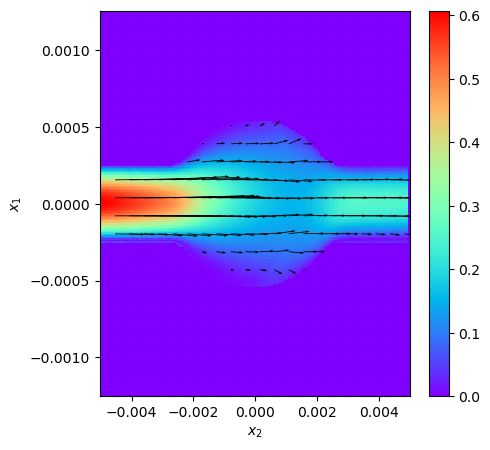

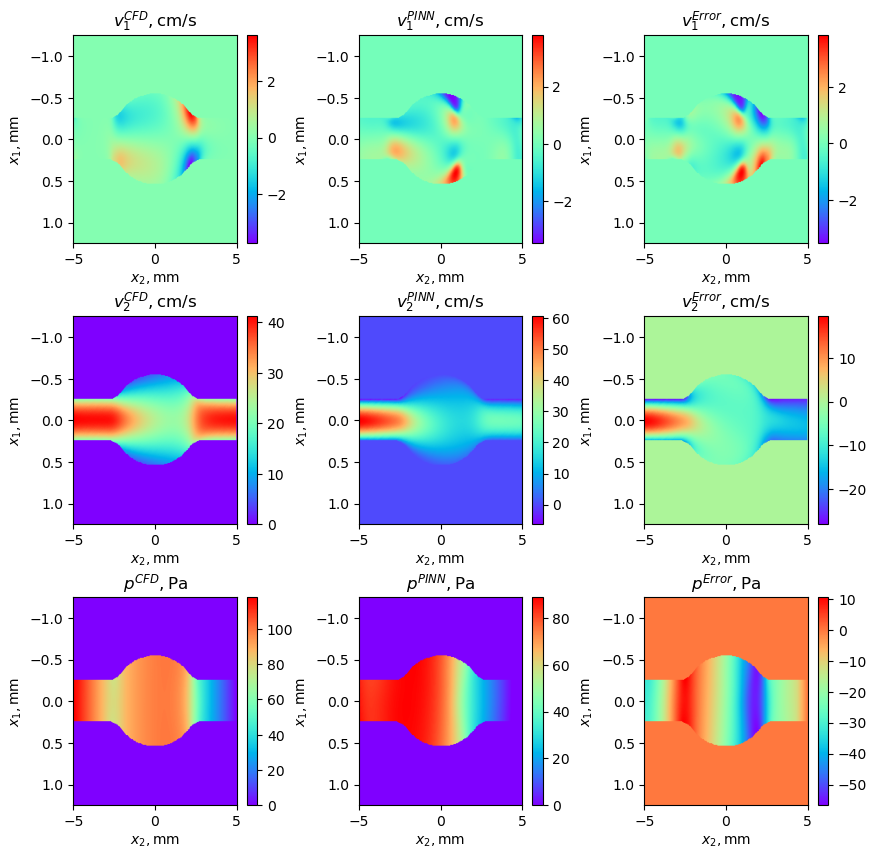

In [32]:
path = 'meshes'
img_path = 'dataset'

with torch.no_grad():
    for i in os.listdir(path):
        print(i)
        for j in os.listdir(os.path.join(path, i)):
            if 'csv' not in j:
                continue
            df = pd.read_csv(os.path.join(path, i, j))
            p_key_1 = df.iloc[0, 0]
            p_key_2 = df.keys()[2]
            df = pd.concat(objs = (df[['Points_0', 'Points_1', p_key_2]][df['Block Name'] == p_key_1].reset_index(),
                                   df[['u_sol_0', 'u_sol_1']][df['Block Name'] == 'TimeSeries_u_sol'].reset_index()),
                                   axis=1)
            
            ind = os.listdir(os.path.join('dataset', i)).index(j.replace('csv', 'png'))

            if 'train' in i:
                mask_ = train_dataset.masks[ind][0]
            elif 'val' in i:
                mask_ = val_dataset.masks[ind][0]

            # ref_1 = float(j.split('_')[1])
            # ref_2 = float(j.split('_')[2])
            # interp = float(j.split('_')[3][:2])

            numbers = re.findall(r'idx_(\d+)_(\d+)_(\d+)\.csv', j)
            ref_1, ref_2, interp = numbers[0]
            ref_1, ref_2, interp = float(ref_1), float(ref_2), float(interp)
            
            # inputs = df[['Points_1', 'Points_1', 'Points_0', 'Points_1', 'Points_0']].to_numpy()
            # inputs[:, 0] = ref_1
            # inputs[:, 1] = ref_2
            # inputs[:, 2] = interp
            # inputs[:, 4] -= 0.005

            inputs = np.zeros((df.shape[0],130))
            img_file_path = os.path.join(img_path,i, os.path.splitext(j)[0] + ".png")
            img = Image.open(img_file_path)
            img_array = np.array(img)
            img_tensor = torch.from_numpy(img_array / 255.0).float().unsqueeze(0).unsqueeze(0).to(DEVICE)
            emb = cae_model.encoder(img_tensor).to('cpu').numpy()
            inputs[:, 0:128] = cae_model.encoder(img_tensor).to('cpu').numpy()
            
            inputs[:, 128] = df[['Points_1']].to_numpy().reshape((df.shape[0],))
            inputs[:, 129] = df[['Points_0']].to_numpy().reshape((df.shape[0],)) - 0.005

            targets = df[['u_sol_1', 'u_sol_0', p_key_2]].to_numpy()
            targets[:, 2] *= 1050
            outputs = model(torch.tensor(inputs).float().to(DEVICE))

            error_v, mean_error_v, v_max, error_p, mean_error_p, p_max = mae(targets, outputs.cpu().numpy()[0], inputs)
            print(ref_1, ref_2, interp)
            print('error_v', error_v, 'mean_error_v', mean_error_v, 'v_max', v_max, 'error_p', error_p, 'mean_error_p', mean_error_p, 'p_max', p_max)
            # visualization_compare(ref_1, ref_2, interp, inputs[inputs[:, 3] > -0.0045], targets[inputs[:, 3] > -0.0045], outputs.cpu().numpy()[0][inputs[:, 3] > -0.0045], mask_.numpy())
            visualization_compare(ref_1, ref_2, interp, inputs[inputs[:, 128] > -0.0045], targets[inputs[:, 128] > -0.0045], outputs.cpu().numpy()[0][inputs[:, 128] > -0.0045], mask_.numpy(), emb[:,0:128])